In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise, Embedding, multiply, concatenate
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time

In [5]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [6]:
train_imgs = []
train_classes = []
class_index = 0
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    print(f'{len(files)} samples in class {class_index}, ({root})')
    for name in files:
        train_imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR))
        train_classes.append(class_index)
    class_index += 1
train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5
train_classes = np.array(train_classes)

60 samples in class 0, (./CUB_200_2011/CUB_200_2011/images-cleaned/001.Black_footed_Albatross)
60 samples in class 1, (./CUB_200_2011/CUB_200_2011/images-cleaned/002.Laysan_Albatross)
58 samples in class 2, (./CUB_200_2011/CUB_200_2011/images-cleaned/003.Sooty_Albatross)
60 samples in class 3, (./CUB_200_2011/CUB_200_2011/images-cleaned/004.Groove_billed_Ani)
44 samples in class 4, (./CUB_200_2011/CUB_200_2011/images-cleaned/005.Crested_Auklet)
41 samples in class 5, (./CUB_200_2011/CUB_200_2011/images-cleaned/006.Least_Auklet)
53 samples in class 6, (./CUB_200_2011/CUB_200_2011/images-cleaned/007.Parakeet_Auklet)
48 samples in class 7, (./CUB_200_2011/CUB_200_2011/images-cleaned/008.Rhinoceros_Auklet)
59 samples in class 8, (./CUB_200_2011/CUB_200_2011/images-cleaned/009.Brewer_Blackbird)
60 samples in class 9, (./CUB_200_2011/CUB_200_2011/images-cleaned/010.Red_winged_Blackbird)
60 samples in class 10, (./CUB_200_2011/CUB_200_2011/images-cleaned/011.Rusty_Blackbird)
56 samples in cla

60 samples in class 92, (./CUB_200_2011/CUB_200_2011/images-cleaned/093.Clark_Nutcracker)
60 samples in class 93, (./CUB_200_2011/CUB_200_2011/images-cleaned/094.White_breasted_Nuthatch)
60 samples in class 94, (./CUB_200_2011/CUB_200_2011/images-cleaned/095.Baltimore_Oriole)
60 samples in class 95, (./CUB_200_2011/CUB_200_2011/images-cleaned/096.Hooded_Oriole)
59 samples in class 96, (./CUB_200_2011/CUB_200_2011/images-cleaned/097.Orchard_Oriole)
60 samples in class 97, (./CUB_200_2011/CUB_200_2011/images-cleaned/098.Scott_Oriole)
60 samples in class 98, (./CUB_200_2011/CUB_200_2011/images-cleaned/099.Ovenbird)
60 samples in class 99, (./CUB_200_2011/CUB_200_2011/images-cleaned/100.Brown_Pelican)
50 samples in class 100, (./CUB_200_2011/CUB_200_2011/images-cleaned/101.White_Pelican)
60 samples in class 101, (./CUB_200_2011/CUB_200_2011/images-cleaned/102.Western_Wood_Pewee)
60 samples in class 102, (./CUB_200_2011/CUB_200_2011/images-cleaned/103.Sayornis)
60 samples in class 103, (./C

60 samples in class 183, (./CUB_200_2011/CUB_200_2011/images-cleaned/184.Louisiana_Waterthrush)
60 samples in class 184, (./CUB_200_2011/CUB_200_2011/images-cleaned/185.Bohemian_Waxwing)
60 samples in class 185, (./CUB_200_2011/CUB_200_2011/images-cleaned/186.Cedar_Waxwing)
50 samples in class 186, (./CUB_200_2011/CUB_200_2011/images-cleaned/187.American_Three_toed_Woodpecker)
60 samples in class 187, (./CUB_200_2011/CUB_200_2011/images-cleaned/188.Pileated_Woodpecker)
60 samples in class 188, (./CUB_200_2011/CUB_200_2011/images-cleaned/189.Red_bellied_Woodpecker)
58 samples in class 189, (./CUB_200_2011/CUB_200_2011/images-cleaned/190.Red_cockaded_Woodpecker)
60 samples in class 190, (./CUB_200_2011/CUB_200_2011/images-cleaned/191.Red_headed_Woodpecker)
60 samples in class 191, (./CUB_200_2011/CUB_200_2011/images-cleaned/192.Downy_Woodpecker)
60 samples in class 192, (./CUB_200_2011/CUB_200_2011/images-cleaned/193.Bewick_Wren)
60 samples in class 193, (./CUB_200_2011/CUB_200_2011/imag

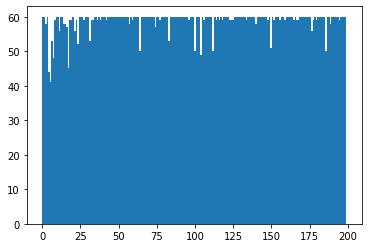

(11788, 64, 64, 3)


In [25]:
plt.hist(train_classes, bins=200)
plt.show()
assert(len(train_imgs) == len(train_classes))
print(train_imgs.shape)

In [218]:
def load_image_attributes():
    train_attrs = np.zeros((train_imgs.shape[0], 312))
    with open('./CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            # For now we don't care about attribute certainty, just if it is present.
            try:
                split = line.split()
                img_id = int(split[0])
                assert(img_id > 0)
                assert(img_id <= 11788)
                attr_id = int(split[1])
                assert(attr_id > 0)
                assert(attr_id <= 312)
                is_present = int(split[2])
                assert(is_present == 0 or is_present == 1)
            except: 
                print(line)
                print(line.split())
                return
            
            train_attrs[img_id-1, attr_id-1] = is_present
    return train_attrs

train_attrs = load_image_attributes().astype('float32')


In [51]:
def make_generator_model(shape):
    
    noise_in = Input(shape=shape)
    attributes_in = Input(shape=(312,))
    
    input_layer = concatenate([noise_in, attributes_in])
    
    x = Dense(16*16*64)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 64))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model([noise_in, attributes_in], x)

In [52]:
generator = make_generator_model((100,))
generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 312)]        0                                            
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 412)          0           input_27[0][0]                   
                                                                 input_28[0][0]                   
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 16384)        6766592     concatenate_12[0][0]       

(312,)


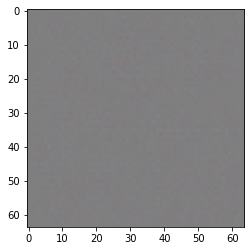

In [131]:
generator = make_generator_model((100,))

noise = np.random.normal(0, 1, 100)
label = train_attrs[0]
print(label.shape)

generated_image = generator.predict( [np.array([noise]), np.array([label])] )[0]
plt.imshow(unnormalize_img(generated_image), )

In [65]:
def make_discriminator_model():
    input_layer = Input((64, 64, 3))
    x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(64)(x) # Probably too small of a dense...
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    valid = Dense(1, activation='sigmoid')(x)
    attributes = Dense(312, activation='sigmoid')(x)
    
    return Model(input_layer, [valid, attributes])

In [128]:
discriminator = make_discriminator_model()
discriminator.summary()
valid, label = discriminator.predict(np.array([generated_image]))


Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 32, 32, 64)   1792        input_62[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_145 (LeakyReLU)     (None, 32, 32, 64)   0           conv2d_60[0][0]                  
__________________________________________________________________________________________________
dropout_75 (Dropout)            (None, 32, 32, 64)   0           leaky_re_lu_145[0][0]            
___________________________________________________________________________________________

In [67]:
cross_entropy = BinaryCrossentropy(from_logits=False)

def discriminator_valid_loss(real_output, fake_output, flip):
    
    if flip:
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.9, maxval=1.0)
        real_labels = tf.random.uniform(real_output.shape, minval=0.0, maxval=0.1)
    else:
        real_labels = tf.random.uniform(real_output.shape, minval=0.9, maxval=1.0)
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.0, maxval=0.1)

        
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

In [68]:
def discriminator_attribute_loss_real(real_output, real_attributes):
    return cross_entropy(real_output, real_attributes)

def discriminator_attribute_loss_fake(fake_output, fake_attributes):
    return cross_entropy(fake_output, fake_attributes)

In [69]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [70]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [243]:
# np.mean(np.sum(train_attrs[:,:7], axis=1))
# np.argmin(np.count_nonzero(train_attrs[:,:9], axis=1))
print('Max has_bill_shape count:', np.max(np.count_nonzero(train_attrs[:, :9], axis=1)))
print('Average of has_bill_shape:', np.mean(np.count_nonzero(train_attrs[:, :9], axis=1)))
print('Stddev of has_bill_shape:', np.std(np.count_nonzero(train_attrs[:, :9], axis=1)))

print('Max has_wing_color count:', np.max(np.count_nonzero(train_attrs[:, 9:24], axis=1)))
print('Average of has_wing_color:', np.mean(np.count_nonzero(train_attrs[:, 9:24], axis=1)))

print('Max has_upperparts_color count:', np.max(np.count_nonzero(train_attrs[:, 24:39], axis=1)))
print('Average of has_upperparts_color:', np.mean(np.count_nonzero(train_attrs[:, 24:39], axis=1)))

print('Max has_underparts_color count:', np.max(np.count_nonzero(train_attrs[:, 39:54], axis=1)))
print('Average of has_underparts_color:', np.mean(np.count_nonzero(train_attrs[:, 39:54], axis=1)))

Max has_bill_shape count: 1
Average of has_bill_shape: 0.9753987105531049
Stddev of has_bill_shape: 0.1549066364118892
Max has_wing_color count: 4
Average of has_wing_color: 1.7254835425856803
Max has_upperparts_color count: 4
Average of has_upperparts_color: 1.6267390566677977
Max has_underparts_color count: 4
Average of has_underparts_color: 1.361723786901934


In [186]:
# @tf.function
def generate_sampled_attrs():
    attrs = tf.Variable(initial_value=tf.zeros([32,312]), dtype=tf.dtypes.float32)
    for i in range(32):
        attrs[i,tf.random.uniform([], minval=0, maxval=9, dtype=tf.dtypes.int32)].assign(1) # Bill Shape
        attrs[i,tf.random.uniform([], minval=9, maxval=24, dtype=tf.dtypes.int32)].assign(1) # Wing Color
        attrs[i,tf.random.uniform([], minval=24, maxval=39, dtype=tf.dtypes.int32)].assign(1) # Upper Parts Color
        attrs[i,tf.random.uniform([], minval=39, maxval=54, dtype=tf.dtypes.int32)].assign(1) # Under Parts Color
        attrs[i,tf.random.uniform([], minval=54, maxval=58, dtype=tf.dtypes.int32)].assign(1) # Breast Pattern
        attrs[i,tf.random.uniform([], minval=24, maxval=39, dtype=tf.dtypes.int32)].assign(1) # Back Color
    
    return attrs

generate_sampled_attrs()

<tf.Variable 'Variable:0' shape=(32, 312) dtype=float32, numpy=
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)>

In [264]:
@tf.function
def train_step(images, attrs, sampled_attrs, flip, warmup):
    noise = tf.random.truncated_normal([32, 100])
    
#     sampled_attrs = tf.cast(tf.random.uniform([32, 312], minval=0, maxval=2, dtype='int32'), 'float32') # Need to make this smarter. Only one 1 per attr.
    
#     attrs = tf.reshape(attrs, (attrs.shape[0], 1))
    
    gen_losses = []
    disc_losses = []
    disc_real_losses = []
    disc_fake_losses = []
    disc_attr_real_losses = []
    disc_attr_fake_losses = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, sampled_attrs], training=True)
        
        real_output, real_attr_output = discriminator(images, training=True)
        fake_output, fake_attr_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss, disc_real_loss, disc_fake_loss = discriminator_valid_loss(real_output, fake_output, flip)
        disc_attr_real_loss = discriminator_attribute_loss_real(real_attr_output, attrs)
        disc_attr_fake_loss = discriminator_attribute_loss_fake(fake_attr_output, sampled_attrs)
        disc_loss += ((2.0 - warmup) * disc_attr_real_loss + warmup * disc_attr_fake_loss)
        
        gen_losses.append(K.mean(gen_loss))
        disc_losses.append(K.mean(disc_loss))
        disc_real_losses.append(K.mean(disc_real_loss))
        disc_fake_losses.append(K.mean(disc_fake_loss))
        disc_attr_real_losses.append(K.mean(disc_attr_real_loss))
        disc_attr_fake_losses.append(K.mean(disc_attr_fake_loss))
    
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_losses, disc_losses, disc_real_losses, disc_fake_losses, disc_attr_real_losses, disc_attr_fake_losses)

In [256]:
def train(train_imgs, train_attrs, epochs, warmup):
    gen_loss_all = []
    disc_loss_all = []
    disc_loss_real_all = []
    disc_loss_fake_all = []
    disc_attr_loss_real_all = []
    disc_attr_loss_fake_all = []
    warmup_step = 1./1000.
    
    num_samples = len(train_imgs)
    batch_counter = 0
    
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = [1, 0]
        disc_loss_epoch = [1, 0]
        disc_loss_real_epoch = [1, 0]
        disc_loss_fake_epoch = [1, 0]
        disc_attr_loss_real_epoch = [1, 0]
        disc_attr_loss_fake_epoch = [1, 0]
        
        seed = np.random.randint(0, 10000)
        np.random.seed(seed)
        np.random.shuffle(train_imgs)
        np.random.seed(seed)
        np.random.shuffle(train_attrs)
        
        for idx, i in enumerate(range(0, num_samples - 32, 32)):
            
            gen_loss_batch, disc_loss_batch, disc_loss_real_batch, disc_loss_fake_batch, disc_attr_loss_real_batch, disc_attr_loss_fake_batch = train_step(train_imgs[i:(i+32)], train_attrs[i:(i+32)], train_attrs[np.random.choice(range(len(train_attrs)), 32, replace=False)], batch_counter % 20 == 0, tf.constant(warmup, dtype='float32'))

            gen_loss_epoch[0] += 1
            disc_loss_epoch[0] += 1
            disc_loss_real_epoch[0] += 1
            disc_loss_fake_epoch[0] += 1
            disc_attr_loss_real_epoch[0] += 1
            disc_attr_loss_fake_epoch[0] += 1
            gen_loss_epoch[1] += np.mean(gen_loss_batch)
            disc_loss_epoch[1] += np.mean(disc_loss_batch)
            disc_loss_real_epoch[1] += np.mean(disc_loss_real_batch)
            disc_loss_fake_epoch[1] += np.mean(disc_loss_fake_batch)
            disc_attr_loss_real_epoch[1] += np.mean(disc_attr_loss_real_batch)
            disc_attr_loss_fake_epoch[1] += np.mean(disc_attr_loss_fake_batch)
            
            batch_counter += 1
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(f'Gen loss: {gen_loss_epoch[1]/gen_loss_epoch[0]}, Disc loss: {disc_loss_epoch[1]/disc_loss_epoch[0]}, Disc valid real loss: {disc_loss_real_epoch[1]/disc_loss_real_epoch[0]}, Disc valid fake loss: {disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0]}, Disc class real loss: {disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0]}, Disc class fake loss: {disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0]}')
        
        gen_loss_all.append(gen_loss_epoch[1]/gen_loss_epoch[0])
        disc_loss_all.append(disc_loss_epoch[1]/disc_loss_epoch[0])
        disc_loss_real_all.append(disc_loss_real_epoch[1]/disc_loss_real_epoch[0])
        disc_loss_fake_all.append(disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0])
        disc_attr_loss_real_all.append(disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0])
        disc_attr_loss_fake_all.append(disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0])
        
        if warmup < 1:
            warmup += warmup_step
    
    return (gen_loss_all, disc_loss_all, disc_loss_real_all, disc_loss_fake_all, disc_attr_loss_real_all, disc_attr_loss_fake_all, warmup)
    


In [257]:
def long_train(starting_checkpoint=0, num_checkpoints=0, checkpoint_interval=0, g_hist=None, d_hist=None, d_real_hist=None, d_fake_hist=None, d_attr_real_hist=None, d_attr_fake_hist=None, noise=None, attr=None, save_files=False, warmup=0.):
    
#     if noise is None:
#         noise = np.random.normal(0, 1, 100)

    if g_hist is None:
        g_hist = []
    
    if d_hist is None:
        d_hist = []
        
    if d_real_hist is None:
        d_real_hist = []
    
    if d_fake_hist is None:
        d_fake_hist = []
        
    if d_attr_real_hist is None:
        d_attr_real_hist = []
        
    if d_attr_fake_hist is None:
        d_attr_fake_hist = []

    for i in range(starting_checkpoint, starting_checkpoint + num_checkpoints):
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('')
        print(f'Starting checkpoint {i}')
        print('')
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        gen_temp, disc_temp, disc_real_temp, disc_fake_temp, disc_attr_real_temp, disc_attr_fake_temp, warmup = train(train_imgs, train_attrs, checkpoint_interval, warmup)
        
        g_hist += gen_temp
        d_hist += disc_temp
        d_real_hist += disc_real_temp
        d_fake_hist += disc_fake_temp
        d_attr_real_hist += disc_attr_real_temp
        d_attr_fake_hist += disc_attr_fake_temp
        generated_image = generator.predict( [np.array([noise]), np.array([attr])])[0]
        plt.imshow(unnormalize_img(generated_image))
        if save_files:
            plt.savefig('./results/prog-imgs/bird-gan-attributes/' + str((i+1)*checkpoint_interval) + '.png')
        plt.show()
        if save_files:
            generator.save_weights('./results/weights/bird-gan-attributes/gen_weights_attributes_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator.save_weights('./results/weights/bird-gan-attributes/disc_weights_attributes_' + str((i+1)*checkpoint_interval) + '.h5')
    
    return starting_checkpoint + num_checkpoints, totalepochs, warmup

In [262]:
discriminator = make_discriminator_model()
generator = make_generator_model((100,))
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [263]:
# To get passed into training function and get modified
# Run cell when starting from scratch
gen_loss_hist = []
disc_loss_hist = []
disc_loss_real_hist = []
disc_loss_fake_hist = []
disc_attr_loss_real_hist = []
disc_attr_loss_fake_hist = []
noise100 = np.random.normal(0, 1, 100)
attr = train_attrs[0]
next_starting_checkpoint = 0
totalepochs = 0
warmup = 1.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 40

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.08455491065979 sec
Gen loss: 1.4721325348386274, Disc loss: 3.6606295528773694, Disc valid real loss: 0.5262562277194284, Disc valid fake loss: 0.48255456834627686, Disc class real loss: 1.4541310126865459, Disc class fake loss: 1.197687751232447
Time for epoch 2 is 14.022621393203735 sec
Gen loss: 1.449810654813358, Disc loss: 3.6513412761171335, Disc valid real loss: 0.5233837316837414, Disc valid fake loss: 0.4827788435831303, Disc class real loss: 1.4566306176224375, Disc class fake loss: 1.1885480787049787
Time for epoch 3 is 13.986129760742188 sec
Gen loss: 1.479149308954151, Disc loss: 3.658778133108041, Disc valid real loss: 0.5256349517885586, Disc valid fake loss: 0.47983695045719305, Disc class real loss: 1.4562533370201505, Disc class fake loss: 1.1970528800313065
Time for epoch 4 is 14.069890975952148 sec
Gen loss: 1.4583186072708791, 

Time for epoch 31 is 14.124941349029541 sec
Gen loss: 1.4716297782210477, Disc loss: 3.6686354284364033, Disc valid real loss: 0.5238345414803927, Disc valid fake loss: 0.4816929602687598, Disc class real loss: 1.4574985643066365, Disc class fake loss: 1.2056093697302386
Time for epoch 32 is 14.14248776435852 sec
Gen loss: 1.4467306746053825, Disc loss: 3.665599198199223, Disc valid real loss: 0.535214849200029, Disc valid fake loss: 0.48097873234813454, Disc class real loss: 1.4594690082519035, Disc class fake loss: 1.189936609287572
Time for epoch 33 is 14.143568515777588 sec
Gen loss: 1.4446519988016062, Disc loss: 3.672562407284248, Disc valid real loss: 0.532400903663015, Disc valid fake loss: 0.4864186564596688, Disc class real loss: 1.4571482111121903, Disc class fake loss: 1.1965946485679648
Time for epoch 34 is 14.12391710281372 sec
Gen loss: 1.4651363920067062, Disc loss: 3.6665435250858627, Disc valid real loss: 0.5281738516114914, Disc valid fake loss: 0.47556261948453704, 

Time for epoch 62 is 14.1880202293396 sec
Gen loss: 1.4697309222001693, Disc loss: 3.6629006642959303, Disc valid real loss: 0.5280506240966197, Disc valid fake loss: 0.4757047885963264, Disc class real loss: 1.4576425658978098, Disc class fake loss: 1.201502691601027
Time for epoch 63 is 14.16677474975586 sec
Gen loss: 1.467550343937344, Disc loss: 3.6903806430537527, Disc valid real loss: 0.5297252399326986, Disc valid fake loss: 0.4871012454595023, Disc class real loss: 1.4551206119661408, Disc class fake loss: 1.2184335460184712
Time for epoch 64 is 14.178886413574219 sec
Gen loss: 1.4688568044161086, Disc loss: 3.652349223935507, Disc valid real loss: 0.5262466954183449, Disc valid fake loss: 0.4758597954825011, Disc class real loss: 1.4553766334606058, Disc class fake loss: 1.1948660883477065
Time for epoch 65 is 14.258322954177856 sec
Gen loss: 1.4444447697662726, Disc loss: 3.672791325302951, Disc valid real loss: 0.5342495617504689, Disc valid fake loss: 0.4850260695306266, Di

Time for epoch 93 is 14.23551344871521 sec
Gen loss: 1.452978353836349, Disc loss: 3.6704343476592687, Disc valid real loss: 0.5317613325790984, Disc valid fake loss: 0.482938131827326, Disc class real loss: 1.4582110194332878, Disc class fake loss: 1.197523868342402
Time for epoch 94 is 14.187490463256836 sec
Gen loss: 1.462192988331079, Disc loss: 3.6665269430413803, Disc valid real loss: 0.5307050710771142, Disc valid fake loss: 0.4840409603060746, Disc class real loss: 1.4574572904323175, Disc class fake loss: 1.1943236195298068
Time for epoch 95 is 14.255681037902832 sec
Gen loss: 1.438568947437979, Disc loss: 3.6673341450006336, Disc valid real loss: 0.527416782569756, Disc valid fake loss: 0.4853299499204165, Disc class real loss: 1.4571648693989285, Disc class fake loss: 1.1974225493304451
Time for epoch 96 is 14.199317455291748 sec
Gen loss: 1.4422082235496543, Disc loss: 3.672107991164293, Disc valid real loss: 0.5337795061955284, Disc valid fake loss: 0.4862722703596441, Dis

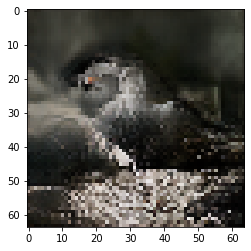

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 41

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.278899431228638 sec
Gen loss: 1.4535486216790632, Disc loss: 3.6636034576550407, Disc valid real loss: 0.5314770826317754, Disc valid fake loss: 0.48114849412990457, Disc class real loss: 1.4577758838813804, Disc class fake loss: 1.1932019935390814
Time for epoch 2 is 14.278555393218994 sec
Gen loss: 1.4662358796370385, Disc loss: 3.6489556895362005, Disc valid real loss: 0.5288509104633072, Disc valid fake loss: 0.47723790534789645, Disc class real loss: 1.4573936129650127, Disc class fake loss: 1.185473257448615
Time for epoch 3 is 14.233095645904541 sec
Gen loss: 1.4365809871575375, Disc loss: 3.6798823131778375, Disc valid real loss: 0.5390362826789298, Disc valid fake loss: 0.4859051620411033, Disc class real loss: 1.457109490061194, Disc class fake loss: 1.1978313864731207
Time for epoch 4 is 14.340269088745117 sec
Gen loss: 1.453461210256023

Time for epoch 31 is 14.266430139541626 sec
Gen loss: 1.4503234599017838, Disc loss: 3.6680000403386144, Disc valid real loss: 0.5351598460661363, Disc valid fake loss: 0.4821671173178407, Disc class real loss: 1.4548210868344398, Disc class fake loss: 1.1958519851935265
Time for epoch 32 is 14.308280229568481 sec
Gen loss: 1.4645498800406933, Disc loss: 3.6526052945351535, Disc valid real loss: 0.5305986627330624, Disc valid fake loss: 0.47680273967060616, Disc class real loss: 1.4578627545013014, Disc class fake loss: 1.1873411408607877
Time for epoch 33 is 14.292560815811157 sec
Gen loss: 1.4670548461640107, Disc loss: 3.676796914439214, Disc valid real loss: 0.5271181139519544, Disc valid fake loss: 0.4852006067913076, Disc class real loss: 1.4575705796399414, Disc class fake loss: 1.2069076112292323
Time for epoch 34 is 14.323078393936157 sec
Gen loss: 1.4533474816862484, Disc loss: 3.6640667727969203, Disc valid real loss: 0.5250181055004358, Disc valid fake loss: 0.4796385287753

Time for epoch 62 is 14.400547504425049 sec
Gen loss: 1.4382014872258917, Disc loss: 3.667872322284109, Disc valid real loss: 0.5288834210010726, Disc valid fake loss: 0.4851494963737684, Disc class real loss: 1.458207653466925, Disc class fake loss: 1.1956317523307594
Time for epoch 63 is 14.325850248336792 sec
Gen loss: 1.4622628401288496, Disc loss: 3.659528952627001, Disc valid real loss: 0.5286050357308169, Disc valid fake loss: 0.47661872777512404, Disc class real loss: 1.459808902042668, Disc class fake loss: 1.1944962924088889
Time for epoch 64 is 14.281076669692993 sec
Gen loss: 1.4821625175837903, Disc loss: 3.65242411515254, Disc valid real loss: 0.5273572632129276, Disc valid fake loss: 0.47251818561295506, Disc class real loss: 1.4562828059442, Disc class fake loss: 1.1962658638553567
Time for epoch 65 is 14.39697813987732 sec
Gen loss: 1.4494837587118794, Disc loss: 3.6870471216475735, Disc valid real loss: 0.5345235657562731, Disc valid fake loss: 0.48220920901957565, Di

Time for epoch 93 is 14.325706958770752 sec
Gen loss: 1.4607079636436815, Disc loss: 3.6660062950154955, Disc valid real loss: 0.5355722657871763, Disc valid fake loss: 0.48414444616493496, Disc class real loss: 1.4580160805849525, Disc class fake loss: 1.18827351305866
Time for epoch 94 is 14.33321213722229 sec
Gen loss: 1.4508510036520195, Disc loss: 3.6555724014757773, Disc valid real loss: 0.5255872614499999, Disc valid fake loss: 0.483686048810075, Disc class real loss: 1.4576980566913842, Disc class fake loss: 1.188601040904761
Time for epoch 95 is 14.265785932540894 sec
Gen loss: 1.4304702239954052, Disc loss: 3.6700895931016464, Disc valid real loss: 0.5341683964580701, Disc valid fake loss: 0.48333130562854654, Disc class real loss: 1.458562480724924, Disc class fake loss: 1.194027411420817
Time for epoch 96 is 14.362016677856445 sec
Gen loss: 1.4262842973719445, Disc loss: 3.679000211601981, Disc valid real loss: 0.5373063409716133, Disc valid fake loss: 0.4898519955353362, D

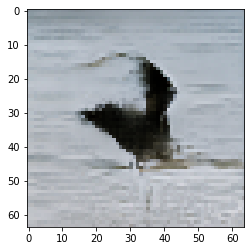

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 42

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.273752450942993 sec
Gen loss: 1.466211303462827, Disc loss: 3.659461920823508, Disc valid real loss: 0.5231496010853992, Disc valid fake loss: 0.48536026768568086, Disc class real loss: 1.4561450752785536, Disc class fake loss: 1.194806973139445
Time for epoch 2 is 14.15963625907898 sec
Gen loss: 1.44042255335707, Disc loss: 3.6687759183609714, Disc valid real loss: 0.5290738339346599, Disc valid fake loss: 0.485741685318753, Disc class real loss: 1.4548941811894982, Disc class fake loss: 1.1990662176757647
Time for epoch 3 is 14.210536003112793 sec
Gen loss: 1.458943652751323, Disc loss: 3.656133287321261, Disc valid real loss: 0.5257926579251845, Disc valid fake loss: 0.48291116670218265, Disc class real loss: 1.4573847430185252, Disc class fake loss: 1.1900447161217047
Time for epoch 4 is 14.236950874328613 sec
Gen loss: 1.4488053444601332, Disc

Time for epoch 31 is 14.337520837783813 sec
Gen loss: 1.4560137350707842, Disc loss: 3.664473865090347, Disc valid real loss: 0.5394247828460321, Disc valid fake loss: 0.4800960839117769, Disc class real loss: 1.4591112595586595, Disc class fake loss: 1.1858417443466704
Time for epoch 32 is 14.209251642227173 sec
Gen loss: 1.4082133598767, Disc loss: 3.6782681373399773, Disc valid real loss: 0.5424483572726004, Disc valid fake loss: 0.48787917863062724, Disc class real loss: 1.4605903816093921, Disc class fake loss: 1.1873502198273573
Time for epoch 33 is 14.334730625152588 sec
Gen loss: 1.4517071092031835, Disc loss: 3.6707263135005466, Disc valid real loss: 0.5370547248903652, Disc valid fake loss: 0.4829043873603428, Disc class real loss: 1.4579597676026466, Disc class fake loss: 1.1928074395430444
Time for epoch 34 is 14.206144571304321 sec
Gen loss: 1.4390170131595477, Disc loss: 3.6676981894950558, Disc valid real loss: 0.530059191915724, Disc valid fake loss: 0.4827379388053243,

Time for epoch 62 is 14.293488264083862 sec
Gen loss: 1.4128898256193332, Disc loss: 3.6709122780538834, Disc valid real loss: 0.5374668909282219, Disc valid fake loss: 0.48891516332703877, Disc class real loss: 1.4574978244983083, Disc class fake loss: 1.1870323970388914
Time for epoch 63 is 14.243159055709839 sec
Gen loss: 1.4266931383913448, Disc loss: 3.665823358184277, Disc valid real loss: 0.5358280327100418, Disc valid fake loss: 0.4864148006529666, Disc class real loss: 1.4576848267216669, Disc class fake loss: 1.1858957009263802
Time for epoch 64 is 14.259389877319336 sec
Gen loss: 1.447986439960759, Disc loss: 3.663072825770391, Disc valid real loss: 0.53550466127835, Disc valid fake loss: 0.47886360959631963, Disc class real loss: 1.457721611994715, Disc class fake loss: 1.1909829358744428
Time for epoch 65 is 14.236848592758179 sec
Gen loss: 1.4478697366507718, Disc loss: 3.663386763595953, Disc valid real loss: 0.5279113198845045, Disc valid fake loss: 0.4861558271940485, 

Time for epoch 93 is 14.37274694442749 sec
Gen loss: 1.4135241505253282, Disc loss: 3.675347457410197, Disc valid real loss: 0.5382647093557084, Disc valid fake loss: 0.4861156706241411, Disc class real loss: 1.4562125031541033, Disc class fake loss: 1.1947545638575463
Time for epoch 94 is 14.271037340164185 sec
Gen loss: 1.4302221504330312, Disc loss: 3.6797296367686614, Disc valid real loss: 0.5331360151774192, Disc valid fake loss: 0.4907921342668818, Disc class real loss: 1.457886713953199, Disc class fake loss: 1.1979147675560742
Time for epoch 95 is 14.250147342681885 sec
Gen loss: 1.426247466224319, Disc loss: 3.668658091123834, Disc valid real loss: 0.533613965601779, Disc valid fake loss: 0.4825901736411945, Disc class real loss: 1.4589211808310614, Disc class fake loss: 1.1935327686268462
Time for epoch 96 is 14.336366415023804 sec
Gen loss: 1.437298931403535, Disc loss: 3.6583986650637494, Disc valid real loss: 0.5263051389840238, Disc valid fake loss: 0.48905526574065045, D

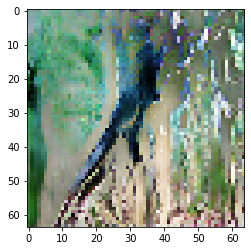

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 43

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.13931393623352 sec
Gen loss: 1.429604428570445, Disc loss: 3.6872204009110368, Disc valid real loss: 0.533146998504313, Disc valid fake loss: 0.49120847198375195, Disc class real loss: 1.4580141251003194, Disc class fake loss: 1.2048508054841824
Time for epoch 2 is 14.170038223266602 sec
Gen loss: 1.4280477048258795, Disc loss: 3.68122158916339, Disc valid real loss: 0.5288718552770331, Disc valid fake loss: 0.4910605036146273, Disc class real loss: 1.4582555126045456, Disc class fake loss: 1.2030337233207413
Time for epoch 3 is 14.18242621421814 sec
Gen loss: 1.4386550611273705, Disc loss: 3.6708201547948325, Disc valid real loss: 0.5304487174765528, Disc valid fake loss: 0.4909998093678699, Disc class real loss: 1.458250300024906, Disc class fake loss: 1.1911213229988327
Time for epoch 4 is 14.2187340259552 sec
Gen loss: 1.4355740537488364, Disc 

Time for epoch 31 is 14.277372121810913 sec
Gen loss: 1.43621632464856, Disc loss: 3.6777995246535715, Disc valid real loss: 0.5333586968380585, Disc valid fake loss: 0.4898578161146583, Disc class real loss: 1.457571102997798, Disc class fake loss: 1.1970119116106008
Time for epoch 32 is 14.27103590965271 sec
Gen loss: 1.451680218947289, Disc loss: 3.6644263519504205, Disc valid real loss: 0.5298065065045344, Disc valid fake loss: 0.4840471716269568, Disc class real loss: 1.4555777249943596, Disc class fake loss: 1.194994950682167
Time for epoch 33 is 14.24836778640747 sec
Gen loss: 1.4689520204939492, Disc loss: 3.665596291947817, Disc valid real loss: 0.5346366990064864, Disc valid fake loss: 0.4799931118804911, Disc class real loss: 1.4560321010548247, Disc class fake loss: 1.1949343766946456
Time for epoch 34 is 14.28261399269104 sec
Gen loss: 1.4416247648275318, Disc loss: 3.659119365661125, Disc valid real loss: 0.5299724195869311, Disc valid fake loss: 0.4841717077787653, Disc 

Time for epoch 62 is 14.348985433578491 sec
Gen loss: 1.4334313714407323, Disc loss: 3.6761455419586926, Disc valid real loss: 0.5337395185054479, Disc valid fake loss: 0.49192375130446625, Disc class real loss: 1.455638392184808, Disc class fake loss: 1.1948438856982926
Time for epoch 63 is 14.188741683959961 sec
Gen loss: 1.415753184941403, Disc loss: 3.6756394555575156, Disc valid real loss: 0.5372147802414933, Disc valid fake loss: 0.49021275313242985, Disc class real loss: 1.4578869229732814, Disc class fake loss: 1.190324993475989
Time for epoch 64 is 14.347508907318115 sec
Gen loss: 1.4437517871055499, Disc loss: 3.6732173728425974, Disc valid real loss: 0.5268434264310976, Disc valid fake loss: 0.4876807468531901, Disc class real loss: 1.4599056857711254, Disc class fake loss: 1.1987875137871844
Time for epoch 65 is 14.291477918624878 sec
Gen loss: 1.4512260457687585, Disc loss: 3.663913118160837, Disc valid real loss: 0.5245385934020769, Disc valid fake loss: 0.485552174369817

Time for epoch 93 is 14.211849212646484 sec
Gen loss: 1.4297030876645551, Disc loss: 3.6788115242955484, Disc valid real loss: 0.5305789300419774, Disc valid fake loss: 0.4902413334788346, Disc class real loss: 1.4571183541925943, Disc class fake loss: 1.200872901493941
Time for epoch 94 is 14.329949140548706 sec
Gen loss: 1.4359088767834796, Disc loss: 3.669325081636589, Disc valid real loss: 0.5311686005695726, Disc valid fake loss: 0.4836328777517407, Disc class real loss: 1.4567367297200975, Disc class fake loss: 1.1977868810255676
Time for epoch 95 is 14.266146659851074 sec
Gen loss: 1.4294355212834469, Disc loss: 3.6721358467246783, Disc valid real loss: 0.5386982488276836, Disc valid fake loss: 0.4852786223255199, Disc class real loss: 1.4568767605758295, Disc class fake loss: 1.1912822183877796
Time for epoch 96 is 14.321476459503174 sec
Gen loss: 1.4174463600324099, Disc loss: 3.683182918605443, Disc valid real loss: 0.5359669183166369, Disc valid fake loss: 0.4902246939295999

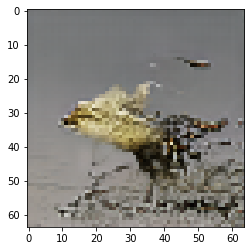

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 44

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.395607709884644 sec
Gen loss: 1.4281590540557696, Disc loss: 3.691037048169268, Disc valid real loss: 0.5330937218859912, Disc valid fake loss: 0.495457902671845, Disc class real loss: 1.4603535324577395, Disc class fake loss: 1.2021318858231955
Time for epoch 2 is 14.233231782913208 sec
Gen loss: 1.4436314467815203, Disc loss: 3.663252728418283, Disc valid real loss: 0.5300897884821181, Disc valid fake loss: 0.4833236046761355, Disc class real loss: 1.4554552382569972, Disc class fake loss: 1.1943840957915557
Time for epoch 3 is 14.289451122283936 sec
Gen loss: 1.4399108347207874, Disc loss: 3.6677787291002146, Disc valid real loss: 0.5343483211548348, Disc valid fake loss: 0.4872426508564936, Disc class real loss: 1.4579605704077536, Disc class fake loss: 1.188227182481347
Time for epoch 4 is 14.403404951095581 sec
Gen loss: 1.451367358851239, Di

Time for epoch 31 is 14.301208019256592 sec
Gen loss: 1.4127828083064176, Disc loss: 3.69244554566174, Disc valid real loss: 0.5442318634450597, Disc valid fake loss: 0.48795260016511127, Disc class real loss: 1.4565480970108735, Disc class fake loss: 1.203712998043877
Time for epoch 32 is 14.316070795059204 sec
Gen loss: 1.4382093356553778, Disc loss: 3.662662285130198, Disc valid real loss: 0.5322086374934126, Disc valid fake loss: 0.48090978447337784, Disc class real loss: 1.4576504734473499, Disc class fake loss: 1.191893392139011
Time for epoch 33 is 14.47897982597351 sec
Gen loss: 1.4344523836603655, Disc loss: 3.6789157248447903, Disc valid real loss: 0.5341785259363128, Disc valid fake loss: 0.49088245226438776, Disc class real loss: 1.4549077261431107, Disc class fake loss: 1.1989470087092744
Time for epoch 34 is 14.272669792175293 sec
Gen loss: 1.4294927220357465, Disc loss: 3.683156469650062, Disc valid real loss: 0.5287483834477298, Disc valid fake loss: 0.48729824793694143

Time for epoch 62 is 14.310385465621948 sec
Gen loss: 1.4045118894680406, Disc loss: 3.6788952964431223, Disc valid real loss: 0.5397044225598415, Disc valid fake loss: 0.4897600712814951, Disc class real loss: 1.45705948386412, Disc class fake loss: 1.1923713073497866
Time for epoch 63 is 14.318046808242798 sec
Gen loss: 1.4357841001939644, Disc loss: 3.670587606223295, Disc valid real loss: 0.539039896271093, Disc valid fake loss: 0.4854225587392564, Disc class real loss: 1.4574561726433153, Disc class fake loss: 1.1886689713007712
Time for epoch 64 is 14.352494955062866 sec
Gen loss: 1.446946261374931, Disc loss: 3.6636724000377705, Disc valid real loss: 0.5238047634683004, Disc valid fake loss: 0.4810327088768243, Disc class real loss: 1.4606102475628944, Disc class fake loss: 1.198224673264718
Time for epoch 65 is 14.306464910507202 sec
Gen loss: 1.4177885590206962, Disc loss: 3.673633159337651, Disc valid real loss: 0.5348220873008253, Disc valid fake loss: 0.4905612761089149, Di

Time for epoch 93 is 14.332382202148438 sec
Gen loss: 1.4152671693140253, Disc loss: 3.677013283499534, Disc valid real loss: 0.540494253076512, Disc valid fake loss: 0.4889969267657779, Disc class real loss: 1.4592143209969126, Disc class fake loss: 1.188307776360654
Time for epoch 94 is 14.304639101028442 sec
Gen loss: 1.4096346705909666, Disc loss: 3.673087001816044, Disc valid real loss: 0.5357882895766881, Disc valid fake loss: 0.49080397249237306, Disc class real loss: 1.452169167317026, Disc class fake loss: 1.1943255688762924
Time for epoch 95 is 14.33794903755188 sec
Gen loss: 1.406149808953448, Disc loss: 3.679290095642007, Disc valid real loss: 0.5388764607389445, Disc valid fake loss: 0.4894613770611564, Disc class real loss: 1.4551363756986169, Disc class fake loss: 1.1958158791549807
Time for epoch 96 is 14.32462453842163 sec
Gen loss: 1.4105632951266074, Disc loss: 3.681899227100982, Disc valid real loss: 0.5417499511545589, Disc valid fake loss: 0.4899665263448627, Disc

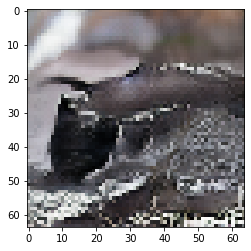

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 45

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.237154960632324 sec
Gen loss: 1.4198895473144242, Disc loss: 3.680061017271626, Disc valid real loss: 0.5381515599524749, Disc valid fake loss: 0.49277528668160686, Disc class real loss: 1.456454444383864, Disc class fake loss: 1.1926797155119215
Time for epoch 2 is 14.320306301116943 sec
Gen loss: 1.4215153849867947, Disc loss: 3.67013950334978, Disc valid real loss: 0.539799713345401, Disc valid fake loss: 0.4848203166390499, Disc class real loss: 1.4585636766945445, Disc class fake loss: 1.1869557905326367
Time for epoch 3 is 14.229307889938354 sec
Gen loss: 1.3731664587165604, Disc loss: 3.724032651441207, Disc valid real loss: 0.5488523986281418, Disc valid fake loss: 0.5033202608264882, Disc class real loss: 1.4614201435228673, Disc class fake loss: 1.2104398399833742
Time for epoch 4 is 14.326043128967285 sec
Gen loss: 1.412683802891553, Dis

Time for epoch 31 is 14.250800132751465 sec
Gen loss: 1.434831061014315, Disc loss: 3.67460453994875, Disc valid real loss: 0.5353232870903119, Disc valid fake loss: 0.4867418991517891, Disc class real loss: 1.4560023006707996, Disc class fake loss: 1.1965370468977021
Time for epoch 32 is 14.328825950622559 sec
Gen loss: 1.4331450197431777, Disc loss: 3.684466603648695, Disc valid real loss: 0.5378917722198052, Disc valid fake loss: 0.4866473929184239, Disc class real loss: 1.4595490674662397, Disc class fake loss: 1.2003783619177697
Time for epoch 33 is 14.233973979949951 sec
Gen loss: 1.4011469016553264, Disc loss: 3.6846851759809787, Disc valid real loss: 0.5451243395404763, Disc valid fake loss: 0.4914016528988918, Disc class real loss: 1.4572211180922139, Disc class fake loss: 1.1909380721529002
Time for epoch 34 is 14.385858535766602 sec
Gen loss: 1.417284159802486, Disc loss: 3.6715830218824266, Disc valid real loss: 0.5348571461390673, Disc valid fake loss: 0.48752301850616125,

Time for epoch 62 is 14.332382440567017 sec
Gen loss: 1.43922354761501, Disc loss: 3.6639599289674423, Disc valid real loss: 0.5312728957755133, Disc valid fake loss: 0.48731999910943874, Disc class real loss: 1.4558350816974794, Disc class fake loss: 1.1895319472160444
Time for epoch 63 is 14.235045433044434 sec
Gen loss: 1.4112054261411755, Disc loss: 3.678563568327162, Disc valid real loss: 0.5408731565727452, Disc valid fake loss: 0.4901213028082034, Disc class real loss: 1.4594126122430735, Disc class fake loss: 1.1881564889496905
Time for epoch 64 is 14.324345588684082 sec
Gen loss: 1.3991572495075422, Disc loss: 3.6741707350826522, Disc valid real loss: 0.5382562012368748, Disc valid fake loss: 0.49245802391835347, Disc class real loss: 1.4579832460176008, Disc class fake loss: 1.1854732706940918
Time for epoch 65 is 14.220181703567505 sec
Gen loss: 1.4218580293138499, Disc loss: 3.670838094985259, Disc valid real loss: 0.531591158329956, Disc valid fake loss: 0.4861528868597697

Time for epoch 93 is 14.198105812072754 sec
Gen loss: 1.4159359941637613, Disc loss: 3.6765199922287692, Disc valid real loss: 0.543671300740746, Disc valid fake loss: 0.4918576970009946, Disc class real loss: 1.460890862353772, Disc class fake loss: 1.1801001250259275
Time for epoch 94 is 14.29590630531311 sec
Gen loss: 1.3958450190743135, Disc loss: 3.6803534211828133, Disc valid real loss: 0.5417121324920395, Disc valid fake loss: 0.49235367153072096, Disc class real loss: 1.459273913042332, Disc class fake loss: 1.1870137042792508
Time for epoch 95 is 14.311886548995972 sec
Gen loss: 1.4034120044734097, Disc loss: 3.681670712907786, Disc valid real loss: 0.5406323562308055, Disc valid fake loss: 0.4909040264805481, Disc class real loss: 1.458914653718633, Disc class fake loss: 1.1912196726010744
Time for epoch 96 is 14.234121561050415 sec
Gen loss: 1.4145790241598113, Disc loss: 3.672015290919358, Disc valid real loss: 0.5402807107947383, Disc valid fake loss: 0.48882903106167386, 

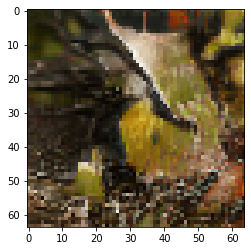

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 46

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.278450727462769 sec
Gen loss: 1.4104294699382007, Disc loss: 3.6676151713704677, Disc valid real loss: 0.5382551651013899, Disc valid fake loss: 0.4932738610399448, Disc class real loss: 1.458531217200323, Disc class fake loss: 1.1775549294825816
Time for epoch 2 is 14.243050336837769 sec
Gen loss: 1.384752509232136, Disc loss: 3.686359390010679, Disc valid real loss: 0.5415600218423983, Disc valid fake loss: 0.4959488631425511, Disc class real loss: 1.4594419238367056, Disc class fake loss: 1.1894085794929568
Time for epoch 3 is 14.235432624816895 sec
Gen loss: 1.409763299029694, Disc loss: 3.6850933195129643, Disc valid real loss: 0.54068576651537, Disc valid fake loss: 0.49095001760214, Disc class real loss: 1.4590429826803646, Disc class fake loss: 1.1944145597416533
Time for epoch 4 is 14.270957946777344 sec
Gen loss: 1.398419481952016, Disc l

Time for epoch 31 is 14.262994050979614 sec
Gen loss: 1.4036232497957017, Disc loss: 3.683294004218042, Disc valid real loss: 0.5400928699065676, Disc valid fake loss: 0.4932918906373383, Disc class real loss: 1.4549140503736047, Disc class fake loss: 1.194995183447189
Time for epoch 32 is 14.352085590362549 sec
Gen loss: 1.3877908041483664, Disc loss: 3.6823715407673907, Disc valid real loss: 0.5461574095051464, Disc valid fake loss: 0.491066865966249, Disc class real loss: 1.459639871992716, Disc class fake loss: 1.185507384257588
Time for epoch 33 is 14.28713583946228 sec
Gen loss: 1.4140319620690696, Disc loss: 3.6823433770073786, Disc valid real loss: 0.543690435527786, Disc valid fake loss: 0.4911938570540772, Disc class real loss: 1.459281934309135, Disc class fake loss: 1.1881771462396555
Time for epoch 34 is 14.290029287338257 sec
Gen loss: 1.3895758038290793, Disc loss: 3.6868046964733256, Disc valid real loss: 0.5438318169375422, Disc valid fake loss: 0.49190233393413263, Di

Time for epoch 62 is 14.296337604522705 sec
Gen loss: 1.4011594984266493, Disc loss: 3.6900648062791284, Disc valid real loss: 0.536775279012799, Disc valid fake loss: 0.49064292849563973, Disc class real loss: 1.4604625133317983, Disc class fake loss: 1.2021840833389985
Time for epoch 63 is 14.315056324005127 sec
Gen loss: 1.4173436626832336, Disc loss: 3.6786697059465943, Disc valid real loss: 0.5433995495159128, Disc valid fake loss: 0.4891918458266633, Disc class real loss: 1.4562180123031947, Disc class fake loss: 1.1898602987046487
Time for epoch 64 is 14.301750659942627 sec
Gen loss: 1.429878261031174, Disc loss: 3.6715408935133356, Disc valid real loss: 0.5352381420975455, Disc valid fake loss: 0.48485839092311495, Disc class real loss: 1.4571220920014833, Disc class fake loss: 1.1943222723679168
Time for epoch 65 is 14.28404426574707 sec
Gen loss: 1.3933060501972188, Disc loss: 3.6852969709773697, Disc valid real loss: 0.5410185119485468, Disc valid fake loss: 0.49251281149019

Time for epoch 93 is 14.303471088409424 sec
Gen loss: 1.404522134359613, Disc loss: 3.6932869196584233, Disc valid real loss: 0.5439756708093452, Disc valid fake loss: 0.4927352531169488, Disc class real loss: 1.4615274005466037, Disc class fake loss: 1.1950485930856327
Time for epoch 94 is 14.25412130355835 sec
Gen loss: 1.4187528347258322, Disc loss: 3.6666059623242715, Disc valid real loss: 0.5341108761990296, Disc valid fake loss: 0.4879806093407194, Disc class real loss: 1.455351688674472, Disc class fake loss: 1.1891628020824132
Time for epoch 95 is 14.257335662841797 sec
Gen loss: 1.3856469509078235, Disc loss: 3.6838806476696395, Disc valid real loss: 0.5415683183566664, Disc valid fake loss: 0.4984425384662339, Disc class real loss: 1.456225699202478, Disc class fake loss: 1.1876440907558452
Time for epoch 96 is 14.272109746932983 sec
Gen loss: 1.3991935947723182, Disc loss: 3.6811650271015117, Disc valid real loss: 0.5465231675119581, Disc valid fake loss: 0.49135453356959957

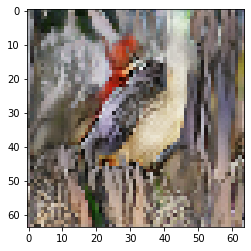

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 47

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.373772859573364 sec
Gen loss: 1.3868204616918796, Disc loss: 3.692104617431558, Disc valid real loss: 0.5401588339954211, Disc valid fake loss: 0.5002101271294643, Disc class real loss: 1.458522335623661, Disc class fake loss: 1.1932133159986356
Time for epoch 2 is 14.290647029876709 sec
Gen loss: 1.3978147920231185, Disc loss: 3.6778920950282235, Disc valid real loss: 0.5401402319349894, Disc valid fake loss: 0.4918212989966075, Disc class real loss: 1.458617173882358, Disc class fake loss: 1.1873133927179869
Time for epoch 3 is 14.277602910995483 sec
Gen loss: 1.406802838087728, Disc loss: 3.6837660988494956, Disc valid real loss: 0.5428244711422339, Disc valid fake loss: 0.4932872624739722, Disc class real loss: 1.458014375149073, Disc class fake loss: 1.1896399881458541
Time for epoch 4 is 14.359137535095215 sec
Gen loss: 1.388163417981569, Dis

Time for epoch 31 is 14.339549541473389 sec
Gen loss: 1.3886140946773333, Disc loss: 3.694776762468705, Disc valid real loss: 0.5463860353964777, Disc valid fake loss: 0.4979087027107797, Disc class real loss: 1.456975723669781, Disc class fake loss: 1.1935062968957069
Time for epoch 32 is 14.307651281356812 sec
Gen loss: 1.3961120084695378, Disc loss: 3.680696026096499, Disc valid real loss: 0.5433085195740387, Disc valid fake loss: 0.4904106264191914, Disc class real loss: 1.4562399271057873, Disc class fake loss: 1.190736950897589
Time for epoch 33 is 14.30032753944397 sec
Gen loss: 1.3824511814892777, Disc loss: 3.6910764931986324, Disc valid real loss: 0.5463757924432677, Disc valid fake loss: 0.49776954573344406, Disc class real loss: 1.455215302263172, Disc class fake loss: 1.1917158494473796
Time for epoch 34 is 14.353463888168335 sec
Gen loss: 1.4141140442876634, Disc loss: 3.674465238886474, Disc valid real loss: 0.5378162942443113, Disc valid fake loss: 0.4883534762917495, D

Time for epoch 62 is 14.34087872505188 sec
Gen loss: 1.3929285014547952, Disc loss: 3.68372869362353, Disc valid real loss: 0.5445162815453237, Disc valid fake loss: 0.48765251371595597, Disc class real loss: 1.4600106762030582, Disc class fake loss: 1.191549218282467
Time for epoch 63 is 14.378073930740356 sec
Gen loss: 1.4097196477538525, Disc loss: 3.686663916440514, Disc valid real loss: 0.5387661317338143, Disc valid fake loss: 0.4972631361103316, Disc class real loss: 1.4542599890613297, Disc class fake loss: 1.1963746604234546
Time for epoch 64 is 14.247532367706299 sec
Gen loss: 1.369948952986296, Disc loss: 3.715985517837814, Disc valid real loss: 0.5524388070352032, Disc valid fake loss: 0.5019786789972931, Disc class real loss: 1.4595448298829035, Disc class fake loss: 1.2020231963496222
Time for epoch 65 is 14.312030792236328 sec
Gen loss: 1.3899403409906197, Disc loss: 3.677527753964349, Disc valid real loss: 0.5373790318242256, Disc valid fake loss: 0.4949821301592075, Di

Time for epoch 93 is 14.343384265899658 sec
Gen loss: 1.4075477943833927, Disc loss: 3.6837981884395528, Disc valid real loss: 0.5434784835108574, Disc valid fake loss: 0.4950608268662843, Disc class real loss: 1.4599481504460983, Disc class fake loss: 1.1853107236588227
Time for epoch 94 is 14.334372282028198 sec
Gen loss: 1.3790721295648798, Disc loss: 3.683271755694051, Disc valid real loss: 0.5294087024400551, Disc valid fake loss: 0.5057146550840156, Disc class real loss: 1.457108920182639, Disc class fake loss: 1.1910394788757572
Time for epoch 95 is 14.292106628417969 sec
Gen loss: 1.4036750292713402, Disc loss: 3.679965241491633, Disc valid real loss: 0.5429368929326696, Disc valid fake loss: 0.48835205385678504, Disc class real loss: 1.455124247687942, Disc class fake loss: 1.193552049194894
Time for epoch 96 is 14.429341316223145 sec
Gen loss: 1.3767430299342809, Disc loss: 3.6916115426112643, Disc valid real loss: 0.545563160161662, Disc valid fake loss: 0.5026208547557273, 

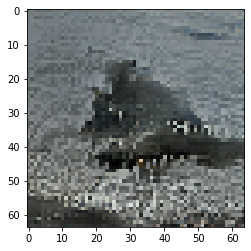

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 48

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.405540704727173 sec
Gen loss: 1.4152488727879717, Disc loss: 3.6849087983935185, Disc valid real loss: 0.5455084942220673, Disc valid fake loss: 0.4904678638388471, Disc class real loss: 1.4566969661531732, Disc class fake loss: 1.1922354732102496
Time for epoch 2 is 14.299145221710205 sec
Gen loss: 1.3801341648024272, Disc loss: 3.696797943373683, Disc valid real loss: 0.5464039872170787, Disc valid fake loss: 0.49931986424011915, Disc class real loss: 1.4570555305739405, Disc class fake loss: 1.1940185524583833
Time for epoch 3 is 14.246683120727539 sec
Gen loss: 1.37689515859454, Disc loss: 3.685757073606579, Disc valid real loss: 0.5470533337857988, Disc valid fake loss: 0.497620488973814, Disc class real loss: 1.4545785673265534, Disc class fake loss: 1.1865046799667482
Time for epoch 4 is 14.244060039520264 sec
Gen loss: 1.4086271417819387, D

Time for epoch 31 is 14.184686183929443 sec
Gen loss: 1.3879702394893823, Disc loss: 3.6923004805557125, Disc valid real loss: 0.5447534945437579, Disc valid fake loss: 0.49645703756389253, Disc class real loss: 1.4543992232501022, Disc class fake loss: 1.1966907319014635
Time for epoch 32 is 14.236871480941772 sec
Gen loss: 1.4005096940813349, Disc loss: 3.67810654834034, Disc valid real loss: 0.5420303763897438, Disc valid fake loss: 0.49326219096739443, Disc class real loss: 1.4593349010317629, Disc class fake loss: 1.1834790814859757
Time for epoch 33 is 14.235593557357788 sec
Gen loss: 1.391735081104082, Disc loss: 3.6934242364836902, Disc valid real loss: 0.5413968771453795, Disc valid fake loss: 0.49800669888493815, Disc class real loss: 1.4594863630568755, Disc class fake loss: 1.1945343011116918
Time for epoch 34 is 14.208895206451416 sec
Gen loss: 1.40829791803024, Disc loss: 3.670310679490004, Disc valid real loss: 0.5401362298626887, Disc valid fake loss: 0.4885936247785563

Time for epoch 62 is 14.248215198516846 sec
Gen loss: 1.3647369408025973, Disc loss: 3.688305290733896, Disc valid real loss: 0.5479052665272379, Disc valid fake loss: 0.49643473840018276, Disc class real loss: 1.4588280903291573, Disc class fake loss: 1.1851371928928345
Time for epoch 63 is 14.228965282440186 sec
Gen loss: 1.3917510858396205, Disc loss: 3.6892739279160334, Disc valid real loss: 0.5477671673304343, Disc valid fake loss: 0.49766902742670155, Disc class real loss: 1.4585702164063286, Disc class fake loss: 1.185267514652676
Time for epoch 64 is 14.358234405517578 sec
Gen loss: 1.3563469273611135, Disc loss: 3.715279840195405, Disc valid real loss: 0.5496357494414983, Disc valid fake loss: 0.5014127076964391, Disc class real loss: 1.4578131046398546, Disc class fake loss: 1.2064182680796802
Time for epoch 65 is 14.262673616409302 sec
Gen loss: 1.392821953225588, Disc loss: 3.6945494494140956, Disc valid real loss: 0.5433346612989741, Disc valid fake loss: 0.498467195567076

Time for epoch 93 is 14.231348276138306 sec
Gen loss: 1.3731049782215419, Disc loss: 3.6951222128984407, Disc valid real loss: 0.5463909839550007, Disc valid fake loss: 0.4976010110158584, Disc class real loss: 1.4577208657251788, Disc class fake loss: 1.193409347760322
Time for epoch 94 is 14.366093397140503 sec
Gen loss: 1.4116299662809708, Disc loss: 3.682614868572411, Disc valid real loss: 0.5406773609682151, Disc valid fake loss: 0.49443255029719696, Disc class real loss: 1.4556462793815426, Disc class fake loss: 1.191858683498248
Time for epoch 95 is 14.252953052520752 sec
Gen loss: 1.37002399668784, Disc loss: 3.7005442009385687, Disc valid real loss: 0.5462041057060728, Disc valid fake loss: 0.4993816517232879, Disc class real loss: 1.4574953511478455, Disc class fake loss: 1.197463092119067
Time for epoch 96 is 14.294835329055786 sec
Gen loss: 1.3772867384964858, Disc loss: 3.7002012871791354, Disc valid real loss: 0.5501203180005557, Disc valid fake loss: 0.4992768125643898, 

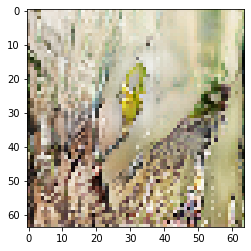

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 49

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.118136405944824 sec
Gen loss: 1.3727548857368428, Disc loss: 3.7002891944998972, Disc valid real loss: 0.5476354036712388, Disc valid fake loss: 0.500614529298896, Disc class real loss: 1.461035514911662, Disc class fake loss: 1.1910037501717647
Time for epoch 2 is 14.256918907165527 sec
Gen loss: 1.3866250821891515, Disc loss: 3.6889794641717017, Disc valid real loss: 0.5398898648052681, Disc valid fake loss: 0.494771975004253, Disc class real loss: 1.457092120072383, Disc class fake loss: 1.1972254908827908
Time for epoch 3 is 14.147563457489014 sec
Gen loss: 1.3948164793857067, Disc loss: 3.6978143463289834, Disc valid real loss: 0.5387172816891658, Disc valid fake loss: 0.5035872923810953, Disc class real loss: 1.460664245494336, Disc class fake loss: 1.1948455224838361
Time for epoch 4 is 14.233493566513062 sec
Gen loss: 1.3837254464141722, Di

Time for epoch 31 is 14.225125789642334 sec
Gen loss: 1.374723490983813, Disc loss: 3.6872830881981993, Disc valid real loss: 0.5501755496996851, Disc valid fake loss: 0.5016211731647088, Disc class real loss: 1.4560791871088954, Disc class fake loss: 1.1794071888859032
Time for epoch 32 is 14.217653274536133 sec
Gen loss: 1.3676746741219912, Disc loss: 3.68560873912925, Disc valid real loss: 0.5410081660198326, Disc valid fake loss: 0.5019412505109782, Disc class real loss: 1.456077775981045, Disc class fake loss: 1.1865815468596894
Time for epoch 33 is 14.253760814666748 sec
Gen loss: 1.3852210755593732, Disc loss: 3.696063791187152, Disc valid real loss: 0.5431448856828013, Disc valid fake loss: 0.5017664772546712, Disc class real loss: 1.4607464659827833, Disc class fake loss: 1.1904059627514867
Time for epoch 34 is 14.163912057876587 sec
Gen loss: 1.3758316506861348, Disc loss: 3.6906679684553687, Disc valid real loss: 0.5432804289064433, Disc valid fake loss: 0.5003473572130126, 

Time for epoch 62 is 14.239973068237305 sec
Gen loss: 1.3575395400608135, Disc loss: 3.701046591528709, Disc valid real loss: 0.555899550436635, Disc valid fake loss: 0.4999673842253078, Disc class real loss: 1.4589121167252703, Disc class fake loss: 1.186267526653724
Time for epoch 63 is 14.196122646331787 sec
Gen loss: 1.3685829464982195, Disc loss: 3.6875081139851393, Disc valid real loss: 0.5421575337729156, Disc valid fake loss: 0.5007661785375135, Disc class real loss: 1.4539925803336993, Disc class fake loss: 1.1905918252177354
Time for epoch 64 is 14.196120262145996 sec
Gen loss: 1.3837834918079015, Disc loss: 3.6862075115607036, Disc valid real loss: 0.5465256800334951, Disc valid fake loss: 0.49423752874539795, Disc class real loss: 1.4562157331120353, Disc class fake loss: 1.1892285792808222
Time for epoch 65 is 14.13529658317566 sec
Gen loss: 1.3573596726265058, Disc loss: 3.6870191394475094, Disc valid real loss: 0.5479920667199908, Disc valid fake loss: 0.5008208482730679

Time for epoch 93 is 14.175388813018799 sec
Gen loss: 1.3739230031889629, Disc loss: 3.7021284691363494, Disc valid real loss: 0.5493097305297852, Disc valid fake loss: 0.5012205275416697, Disc class real loss: 1.4564134160354532, Disc class fake loss: 1.1951848055289043
Time for epoch 94 is 14.298876523971558 sec
Gen loss: 1.3629019935602742, Disc loss: 3.692345237344261, Disc valid real loss: 0.5472493822658612, Disc valid fake loss: 0.4985681906302124, Disc class real loss: 1.4535168470729012, Disc class fake loss: 1.1930108128524408
Time for epoch 95 is 14.238471031188965 sec
Gen loss: 1.3745014573823469, Disc loss: 3.6811994646945942, Disc valid real loss: 0.5420239195429536, Disc valid fake loss: 0.4957337593483085, Disc class real loss: 1.4565221907969736, Disc class fake loss: 1.186919589675862
Time for epoch 96 is 14.307907581329346 sec
Gen loss: 1.3942897041961753, Disc loss: 3.6954925990686185, Disc valid real loss: 0.5434734482106155, Disc valid fake loss: 0.501674254977606

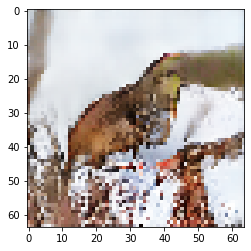

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 50

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.185817956924438 sec
Gen loss: 1.3772492046924787, Disc loss: 3.6987279869999665, Disc valid real loss: 0.5503857842467341, Disc valid fake loss: 0.49889206967056604, Disc class real loss: 1.4546556928293493, Disc class fake loss: 1.1947944351651159
Time for epoch 2 is 14.213750839233398 sec
Gen loss: 1.3823605685376217, Disc loss: 3.6915723611991904, Disc valid real loss: 0.5406107781379204, Disc valid fake loss: 0.49415930047590884, Disc class real loss: 1.4581892777910723, Disc class fake loss: 1.1986130151322218
Time for epoch 3 is 14.158352851867676 sec
Gen loss: 1.3469002170937494, Disc loss: 3.709561320178231, Disc valid real loss: 0.5566846821204756, Disc valid fake loss: 0.505362068007632, Disc class real loss: 1.4564965817986466, Disc class fake loss: 1.1910179953588056
Time for epoch 4 is 14.190436840057373 sec
Gen loss: 1.364515135927898

Time for epoch 31 is 14.230509281158447 sec
Gen loss: 1.3774712408784282, Disc loss: 3.6938080438753453, Disc valid real loss: 0.5495857847576865, Disc valid fake loss: 0.4978957106750509, Disc class real loss: 1.4584215278547954, Disc class fake loss: 1.18790502260694
Time for epoch 32 is 14.233083009719849 sec
Gen loss: 1.3771713332432072, Disc loss: 3.6864247819595546, Disc valid real loss: 0.5374304844434992, Disc valid fake loss: 0.5000299942202684, Disc class real loss: 1.4573032668612513, Disc class fake loss: 1.1916610332039315
Time for epoch 33 is 14.149318218231201 sec
Gen loss: 1.3562936592231274, Disc loss: 3.7058583766141235, Disc valid real loss: 0.5555016749758062, Disc valid fake loss: 0.5063985571628664, Disc class real loss: 1.4540506119973615, Disc class fake loss: 1.1899075323973245
Time for epoch 34 is 14.24555516242981 sec
Gen loss: 1.3570930237369485, Disc loss: 3.7011765238392322, Disc valid real loss: 0.547540122254431, Disc valid fake loss: 0.5026718239151042,

Time for epoch 62 is 14.212698459625244 sec
Gen loss: 1.368468658710883, Disc loss: 3.6995312030399394, Disc valid real loss: 0.5490471005924349, Disc valid fake loss: 0.49805183268497955, Disc class real loss: 1.458935649737433, Disc class fake loss: 1.1934966118678167
Time for epoch 63 is 14.15938663482666 sec
Gen loss: 1.3736293477417654, Disc loss: 3.69546817699422, Disc valid real loss: 0.5398568842146132, Disc valid fake loss: 0.5045713346178938, Disc class real loss: 1.457903050794834, Disc class fake loss: 1.1931368910523288
Time for epoch 64 is 14.266883373260498 sec
Gen loss: 1.3795359512654746, Disc loss: 3.685539894956883, Disc valid real loss: 0.5453133894014488, Disc valid fake loss: 0.4975026964656706, Disc class real loss: 1.4568429674882553, Disc class fake loss: 1.1858808365940725
Time for epoch 65 is 14.17632794380188 sec
Gen loss: 1.3711750148757686, Disc loss: 3.69717544721071, Disc valid real loss: 0.5498964714648601, Disc valid fake loss: 0.4985783960276503, Disc

Time for epoch 93 is 14.125402927398682 sec
Gen loss: 1.3480845609008458, Disc loss: 3.701176487010346, Disc valid real loss: 0.5526459584552744, Disc valid fake loss: 0.5087917684539547, Disc class real loss: 1.458303430216099, Disc class fake loss: 1.1814353302888432
Time for epoch 94 is 14.246851921081543 sec
Gen loss: 1.3687468295497947, Disc loss: 3.688605764694007, Disc valid real loss: 0.5523678140265509, Disc valid fake loss: 0.49834159993866917, Disc class real loss: 1.457672774307127, Disc class fake loss: 1.1802235783600226
Time for epoch 95 is 14.112757682800293 sec
Gen loss: 1.3644211657325103, Disc loss: 3.688103202235731, Disc valid real loss: 0.5475476197595519, Disc valid fake loss: 0.497703560403369, Disc class real loss: 1.4581366451129034, Disc class fake loss: 1.1847153703371684
Time for epoch 96 is 14.138376951217651 sec
Gen loss: 1.3714566447224397, Disc loss: 3.7134748920192564, Disc valid real loss: 0.5568417595007878, Disc valid fake loss: 0.5020346615695694, 

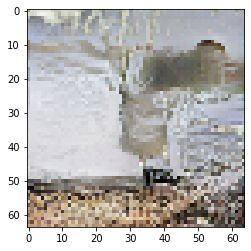

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 51

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.227531671524048 sec
Gen loss: 1.363779708945008, Disc loss: 3.7024063947724133, Disc valid real loss: 0.5514268342072401, Disc valid fake loss: 0.5046419072441939, Disc class real loss: 1.4581172585810427, Disc class fake loss: 1.1882203836751177
Time for epoch 2 is 14.225763082504272 sec
Gen loss: 1.3567834556264282, Disc loss: 3.6903574531317402, Disc valid real loss: 0.5509004040462214, Disc valid fake loss: 0.49949639429891013, Disc class real loss: 1.457806168532953, Disc class fake loss: 1.1821544881112531
Time for epoch 3 is 14.26179814338684 sec
Gen loss: 1.3678967502059005, Disc loss: 3.7008657184073597, Disc valid real loss: 0.5469602010437467, Disc valid fake loss: 0.5055250832381933, Disc class real loss: 1.457685674755231, Disc class fake loss: 1.1906947592086585
Time for epoch 4 is 14.263777494430542 sec
Gen loss: 1.3823158689307649, 

Time for epoch 31 is 14.257060289382935 sec
Gen loss: 1.342384470510612, Disc loss: 3.715894721710908, Disc valid real loss: 0.5591313515090683, Disc valid fake loss: 0.5083948826079123, Disc class real loss: 1.456857618277635, Disc class fake loss: 1.1915108731122521
Time for epoch 32 is 14.214123964309692 sec
Gen loss: 1.3467000079994926, Disc loss: 3.7015757657648103, Disc valid real loss: 0.5464422676944474, Disc valid fake loss: 0.5091256397526439, Disc class real loss: 1.460270281406599, Disc class fake loss: 1.1857375890258852
Time for epoch 33 is 14.263639450073242 sec
Gen loss: 1.3695147641629062, Disc loss: 3.6942713544943793, Disc valid real loss: 0.550198808595094, Disc valid fake loss: 0.5004255537418169, Disc class real loss: 1.4558660570521988, Disc class fake loss: 1.1877809330053768
Time for epoch 34 is 14.30809497833252 sec
Gen loss: 1.3716921473583232, Disc loss: 3.6898102566478697, Disc valid real loss: 0.5490232657610885, Disc valid fake loss: 0.4965767845067228, D

Time for epoch 62 is 14.239686489105225 sec
Gen loss: 1.3726632309153797, Disc loss: 3.69315745772385, Disc valid real loss: 0.5423604788657449, Disc valid fake loss: 0.4981846199610692, Disc class real loss: 1.4575790783900233, Disc class fake loss: 1.1950332761456972
Time for epoch 63 is 14.349277973175049 sec
Gen loss: 1.3423296940035936, Disc loss: 3.7123985432673923, Disc valid real loss: 0.5546260708715858, Disc valid fake loss: 0.5075222248145881, Disc class real loss: 1.4577433177772252, Disc class fake loss: 1.1925069302078184
Time for epoch 64 is 14.267317056655884 sec
Gen loss: 1.3700734157226273, Disc loss: 3.6991190231912503, Disc valid real loss: 0.5467341680352281, Disc valid fake loss: 0.5037574241477946, Disc class real loss: 1.4573052268687303, Disc class fake loss: 1.1913221932362088
Time for epoch 65 is 14.230133533477783 sec
Gen loss: 1.3254546389024109, Disc loss: 3.7130881402550675, Disc valid real loss: 0.5557919260124528, Disc valid fake loss: 0.506298976215889

Time for epoch 93 is 14.342477560043335 sec
Gen loss: 1.3727717386674751, Disc loss: 3.70817994166842, Disc valid real loss: 0.5495167710593722, Disc valid fake loss: 0.5062347907360977, Disc class real loss: 1.4591621467414586, Disc class fake loss: 1.1932662389465787
Time for epoch 94 is 14.306239366531372 sec
Gen loss: 1.3332297504755863, Disc loss: 3.7084814526524323, Disc valid real loss: 0.5576099681498882, Disc valid fake loss: 0.5052379467461491, Disc class real loss: 1.459217222079352, Disc class fake loss: 1.1864163243996741
Time for epoch 95 is 14.183701276779175 sec
Gen loss: 1.3650015191980172, Disc loss: 3.6936577613437724, Disc valid real loss: 0.5441437315165512, Disc valid fake loss: 0.5001714535683475, Disc class real loss: 1.4607442316970205, Disc class fake loss: 1.1885983462579206
Time for epoch 96 is 14.265273332595825 sec
Gen loss: 1.348413979457969, Disc loss: 3.7077011344878654, Disc valid real loss: 0.5503862864441342, Disc valid fake loss: 0.513724130747441, 

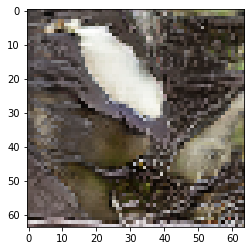

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 52

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.14076542854309 sec
Gen loss: 1.3465048796762296, Disc loss: 3.700702152278042, Disc valid real loss: 0.5488605539650129, Disc valid fake loss: 0.5082886846569495, Disc class real loss: 1.4621082098503424, Disc class fake loss: 1.1814447024327306
Time for epoch 2 is 14.22436809539795 sec
Gen loss: 1.3628741202315664, Disc loss: 3.697555540699946, Disc valid real loss: 0.5476730082254746, Disc valid fake loss: 0.5004366463438928, Disc class real loss: 1.457316320116927, Disc class fake loss: 1.192129574493987
Time for epoch 3 is 14.21626353263855 sec
Gen loss: 1.3454233664807265, Disc loss: 3.704199715358455, Disc valid real loss: 0.5546630305972525, Disc valid fake loss: 0.507865083330692, Disc class real loss: 1.4589808843323209, Disc class fake loss: 1.1826907042565384
Time for epoch 4 is 14.161954879760742 sec
Gen loss: 1.3649856608088424, Disc l

Time for epoch 31 is 14.17816972732544 sec
Gen loss: 1.3468000228165935, Disc loss: 3.712416387185818, Disc valid real loss: 0.5588688122709269, Disc valid fake loss: 0.5085487849505613, Disc class real loss: 1.4600981955282732, Disc class fake loss: 1.184900588620969
Time for epoch 32 is 14.271433115005493 sec
Gen loss: 1.34967171742018, Disc loss: 3.7067974356777946, Disc valid real loss: 0.554080296257324, Disc valid fake loss: 0.501928444719573, Disc class real loss: 1.4631033580154584, Disc class fake loss: 1.1876853402391037
Time for epoch 33 is 14.254415035247803 sec
Gen loss: 1.3292577970964798, Disc loss: 3.7123939512867916, Disc valid real loss: 0.5555624235774766, Disc valid fake loss: 0.5103848672656186, Disc class real loss: 1.4611458216256243, Disc class fake loss: 1.1853008194344477
Time for epoch 34 is 14.279151916503906 sec
Gen loss: 1.3616833447763914, Disc loss: 3.698038611631729, Disc valid real loss: 0.5461350769046845, Disc valid fake loss: 0.5032095278343212, Dis

Time for epoch 62 is 14.275298357009888 sec
Gen loss: 1.3359634488578733, Disc loss: 3.705089769389248, Disc valid real loss: 0.5484920691668502, Disc valid fake loss: 0.5120632831804798, Disc class real loss: 1.4586305256458478, Disc class fake loss: 1.1859038982611039
Time for epoch 63 is 14.147861003875732 sec
Gen loss: 1.330743974947994, Disc loss: 3.722769151212077, Disc valid real loss: 0.5614522089803122, Disc valid fake loss: 0.511842355576311, Disc class real loss: 1.458896528737655, Disc class fake loss: 1.1905780628444702
Time for epoch 64 is 14.199327945709229 sec
Gen loss: 1.3517158225299866, Disc loss: 3.69480948008819, Disc valid real loss: 0.5465232333355157, Disc valid fake loss: 0.5045188384327463, Disc class real loss: 1.461785429538427, Disc class fake loss: 1.181981983385112
Time for epoch 65 is 14.29304051399231 sec
Gen loss: 1.3520478728987013, Disc loss: 3.7029612710482382, Disc valid real loss: 0.5511930955619346, Disc valid fake loss: 0.5063330708803523, Disc 

Time for epoch 93 is 14.201457738876343 sec
Gen loss: 1.355133274221808, Disc loss: 3.701265371265773, Disc valid real loss: 0.5521923620203323, Disc valid fake loss: 0.5061312388921495, Disc class real loss: 1.4603335311419272, Disc class fake loss: 1.1826082366268809
Time for epoch 94 is 14.244261741638184 sec
Gen loss: 1.334221215752082, Disc loss: 3.704267409435779, Disc valid real loss: 0.5518770491689201, Disc valid fake loss: 0.5105225762862177, Disc class real loss: 1.458807260686466, Disc class fake loss: 1.1830605190943897
Time for epoch 95 is 14.378767013549805 sec
Gen loss: 1.3460718705079098, Disc loss: 3.7061605414723964, Disc valid real loss: 0.549731885353078, Disc valid fake loss: 0.5070325117608719, Disc class real loss: 1.4566184330761918, Disc class fake loss: 1.1927777029634492
Time for epoch 96 is 14.244482517242432 sec
Gen loss: 1.3452389750700333, Disc loss: 3.699308890314283, Disc valid real loss: 0.5569127001736546, Disc valid fake loss: 0.5057282958250382, Di

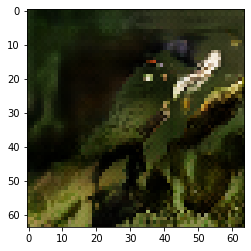

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 53

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.17805552482605 sec
Gen loss: 1.3154198617793034, Disc loss: 3.7253293409580137, Disc valid real loss: 0.5579060792599914, Disc valid fake loss: 0.5186761278447097, Disc class real loss: 1.4602422223181581, Disc class fake loss: 1.188504922357678
Time for epoch 2 is 14.247028350830078 sec
Gen loss: 1.330558911733188, Disc loss: 3.709245420083767, Disc valid real loss: 0.5559967350022903, Disc valid fake loss: 0.5070960307670479, Disc class real loss: 1.4595572350794062, Disc class fake loss: 1.1865954235963383
Time for epoch 3 is 14.148399829864502 sec
Gen loss: 1.3372365048907313, Disc loss: 3.7063598309752095, Disc valid real loss: 0.5537977067597191, Disc valid fake loss: 0.5103777970078838, Disc class real loss: 1.4603622418432054, Disc class fake loss: 1.181822091583314
Time for epoch 4 is 14.169089794158936 sec
Gen loss: 1.3542381392584906, Di

Time for epoch 31 is 14.182194948196411 sec
Gen loss: 1.326917168570728, Disc loss: 3.719409969764027, Disc valid real loss: 0.553046630730797, Disc valid fake loss: 0.5163079937945213, Disc class real loss: 1.4622629829215485, Disc class fake loss: 1.1877923481832675
Time for epoch 32 is 14.207844495773315 sec
Gen loss: 1.3102326414126368, Disc loss: 3.7151636114611537, Disc valid real loss: 0.5614376396829197, Disc valid fake loss: 0.5135126818970936, Disc class real loss: 1.456310839833929, Disc class fake loss: 1.1839024429398823
Time for epoch 33 is 14.277065515518188 sec
Gen loss: 1.349446401363466, Disc loss: 3.7101727197486856, Disc valid real loss: 0.5538359740723763, Disc valid fake loss: 0.5072039771209241, Disc class real loss: 1.4583291112568966, Disc class fake loss: 1.1908036691709585
Time for epoch 34 is 14.351124286651611 sec
Gen loss: 1.3427372489195206, Disc loss: 3.7020241619771737, Disc valid real loss: 0.5521627121016908, Disc valid fake loss: 0.5080325123740406, 

Time for epoch 62 is 14.282225131988525 sec
Gen loss: 1.3290282197114898, Disc loss: 3.712323654634843, Disc valid real loss: 0.5641284471120291, Disc valid fake loss: 0.5065722538203727, Disc class real loss: 1.4587601752785164, Disc class fake loss: 1.182862782058354
Time for epoch 63 is 14.160134315490723 sec
Gen loss: 1.3443966855201617, Disc loss: 3.7060022257207854, Disc valid real loss: 0.5544639195853133, Disc valid fake loss: 0.508084034289771, Disc class real loss: 1.4624057061626983, Disc class fake loss: 1.181048575940171
Time for epoch 64 is 14.24179744720459 sec
Gen loss: 1.3239945040808783, Disc loss: 3.7209627764011786, Disc valid real loss: 0.5590304439145375, Disc valid fake loss: 0.5087928301112116, Disc class real loss: 1.4613263674867831, Disc class fake loss: 1.1918131319811027
Time for epoch 65 is 14.246635437011719 sec
Gen loss: 1.31771871714088, Disc loss: 3.7126983394467734, Disc valid real loss: 0.5558785812318486, Disc valid fake loss: 0.5138576424057245, Di

Time for epoch 93 is 14.203387260437012 sec
Gen loss: 1.3432409710031215, Disc loss: 3.718523159259703, Disc valid real loss: 0.5539604899521443, Disc valid fake loss: 0.5104333769661301, Disc class real loss: 1.457330093474246, Disc class fake loss: 1.1967992036323236
Time for epoch 94 is 14.294609546661377 sec
Gen loss: 1.3199511373915322, Disc loss: 3.714247039340053, Disc valid real loss: 0.5641975754967873, Disc valid fake loss: 0.5099408423028341, Disc class real loss: 1.4585521857589887, Disc class fake loss: 1.1815564317431877
Time for epoch 95 is 14.228808641433716 sec
Gen loss: 1.3320615656653716, Disc loss: 3.7002349365048293, Disc valid real loss: 0.5508370698305972, Disc valid fake loss: 0.5091289615404961, Disc class real loss: 1.4598650463874423, Disc class fake loss: 1.1804038654497968
Time for epoch 96 is 14.323747634887695 sec
Gen loss: 1.3197274140226163, Disc loss: 3.720662507261364, Disc valid real loss: 0.5607818444246845, Disc valid fake loss: 0.5142582710680923,

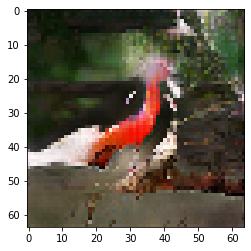

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 54

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.360918760299683 sec
Gen loss: 1.3220685836745472, Disc loss: 3.719144539458319, Disc valid real loss: 0.5606396687709219, Disc valid fake loss: 0.5137712443424111, Disc class real loss: 1.45917077245428, Disc class fake loss: 1.1855628605134443
Time for epoch 2 is 14.279090166091919 sec
Gen loss: 1.3671118447451087, Disc loss: 3.707140781045929, Disc valid real loss: 0.5469893957702772, Disc valid fake loss: 0.5036215886352507, Disc class real loss: 1.458818257662662, Disc class fake loss: 1.1977115342933633
Time for epoch 3 is 14.324768304824829 sec
Gen loss: 1.3261795525305315, Disc loss: 3.7150710049037365, Disc valid real loss: 0.5568653636670048, Disc valid fake loss: 0.5126712272968396, Disc class real loss: 1.463067314489101, Disc class fake loss: 1.1824670971893683
Time for epoch 4 is 14.362789869308472 sec
Gen loss: 1.3290251952199754, Dis

Time for epoch 31 is 14.276593685150146 sec
Gen loss: 1.3289140805319395, Disc loss: 3.7292104633196907, Disc valid real loss: 0.5558232648908931, Disc valid fake loss: 0.5165274237714162, Disc class real loss: 1.4599866734610663, Disc class fake loss: 1.1968730974003552
Time for epoch 32 is 14.308804750442505 sec
Gen loss: 1.3272256838273873, Disc loss: 3.7084299755613332, Disc valid real loss: 0.5488796523269922, Disc valid fake loss: 0.5081067523820614, Disc class real loss: 1.460526196937251, Disc class fake loss: 1.1909173723804918
Time for epoch 33 is 14.253992795944214 sec
Gen loss: 1.3207412759462993, Disc loss: 3.7217409662437957, Disc valid real loss: 0.5578880246254164, Disc valid fake loss: 0.5192531137285517, Disc class real loss: 1.4579266216050641, Disc class fake loss: 1.1866732041041057
Time for epoch 34 is 14.303556203842163 sec
Gen loss: 1.3270747818274873, Disc loss: 3.7090055309337004, Disc valid real loss: 0.5573974577230489, Disc valid fake loss: 0.50507126106479

Time for epoch 62 is 14.30219578742981 sec
Gen loss: 1.3333771538928272, Disc loss: 3.723847775601436, Disc valid real loss: 0.549129901055075, Disc valid fake loss: 0.5154378044249889, Disc class real loss: 1.4593066132165553, Disc class fake loss: 1.1999734585201192
Time for epoch 63 is 14.27915906906128 sec
Gen loss: 1.3348690193843067, Disc loss: 3.7249096615850763, Disc valid real loss: 0.5628432551535164, Disc valid fake loss: 0.5091729344229711, Disc class real loss: 1.4591703263078601, Disc class fake loss: 1.1937231463468494
Time for epoch 64 is 14.289573431015015 sec
Gen loss: 1.3251659648851328, Disc loss: 3.712674417469883, Disc valid real loss: 0.5561521578287367, Disc valid fake loss: 0.5094134078277806, Disc class real loss: 1.4602426897865648, Disc class fake loss: 1.1868661551617672
Time for epoch 65 is 14.336148262023926 sec
Gen loss: 1.3297084875223113, Disc loss: 3.6976174416580823, Disc valid real loss: 0.5581439673739074, Disc valid fake loss: 0.5049773822954999, 

Time for epoch 93 is 14.408841371536255 sec
Gen loss: 1.3210031692251603, Disc loss: 3.72900256684156, Disc valid real loss: 0.5617093367143698, Disc valid fake loss: 0.5163490771439664, Disc class real loss: 1.4575147722471697, Disc class fake loss: 1.193429371367302
Time for epoch 94 is 14.343295335769653 sec
Gen loss: 1.322329278722365, Disc loss: 3.7137526496639097, Disc valid real loss: 0.555104181130081, Disc valid fake loss: 0.5151653192069149, Disc class real loss: 1.4562343517293128, Disc class fake loss: 1.1872488053510506
Time for epoch 95 is 14.3172447681427 sec
Gen loss: 1.31536252243409, Disc loss: 3.7160215791324935, Disc valid real loss: 0.5512693854689921, Disc valid fake loss: 0.5135014775161174, Disc class real loss: 1.459646844282383, Disc class fake loss: 1.191603872511122
Time for epoch 96 is 14.33001446723938 sec
Gen loss: 1.3164591160893118, Disc loss: 3.733843165038401, Disc valid real loss: 0.5644664543107919, Disc valid fake loss: 0.5160367521167124, Disc cla

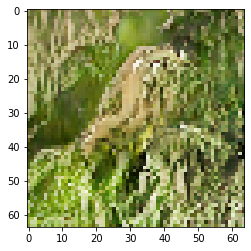

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 55

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.267643928527832 sec
Gen loss: 1.3251514307205594, Disc loss: 3.7252762737636, Disc valid real loss: 0.5605389277140299, Disc valid fake loss: 0.5167027206278751, Disc class real loss: 1.4572253517988252, Disc class fake loss: 1.190809272492158
Time for epoch 2 is 14.280901193618774 sec
Gen loss: 1.3143566733776393, Disc loss: 3.718463059686387, Disc valid real loss: 0.5570809051273314, Disc valid fake loss: 0.5135838213328746, Disc class real loss: 1.4595360345633694, Disc class fake loss: 1.1882622991474017
Time for epoch 3 is 14.279369354248047 sec
Gen loss: 1.323682204979222, Disc loss: 3.7098277564940414, Disc valid real loss: 0.5507470062431604, Disc valid fake loss: 0.5200366675046079, Disc class real loss: 1.4598051322507988, Disc class fake loss: 1.1792389522723066
Time for epoch 4 is 14.239305019378662 sec
Gen loss: 1.3238753999474895, Dis

Time for epoch 31 is 14.431361675262451 sec
Gen loss: 1.3092676091000317, Disc loss: 3.720416720320539, Disc valid real loss: 0.5601999998738773, Disc valid fake loss: 0.5143735870759338, Disc class real loss: 1.459521473261722, Disc class fake loss: 1.1863216533247372
Time for epoch 32 is 14.32798171043396 sec
Gen loss: 1.3146444476716888, Disc loss: 3.7103571588107886, Disc valid real loss: 0.5552018388176998, Disc valid fake loss: 0.5156236748062175, Disc class real loss: 1.4604938553600777, Disc class fake loss: 1.1790377886960823
Time for epoch 33 is 14.19672155380249 sec
Gen loss: 1.3214387977672464, Disc loss: 3.737330710661767, Disc valid real loss: 0.5612196986914327, Disc valid fake loss: 0.5145914179038226, Disc class real loss: 1.457205694865405, Disc class fake loss: 1.204313903804717
Time for epoch 34 is 14.293397665023804 sec
Gen loss: 1.3244278006114287, Disc loss: 3.7159614207621834, Disc valid real loss: 0.55399074504369, Disc valid fake loss: 0.5143615632522397, Disc

Time for epoch 62 is 14.254925727844238 sec
Gen loss: 1.3260700190616495, Disc loss: 3.712068883384146, Disc valid real loss: 0.5565823683247657, Disc valid fake loss: 0.5098764858433225, Disc class real loss: 1.4575925890992327, Disc class fake loss: 1.1880174443973759
Time for epoch 63 is 14.264135360717773 sec
Gen loss: 1.3273745797837007, Disc loss: 3.721769527368106, Disc valid real loss: 0.5521165190673456, Disc valid fake loss: 0.5211128354234101, Disc class real loss: 1.4575792932251928, Disc class fake loss: 1.1909608795713926
Time for epoch 64 is 14.272693634033203 sec
Gen loss: 1.3104657551783534, Disc loss: 3.7278953186541717, Disc valid real loss: 0.5515994002340932, Disc valid fake loss: 0.520311103442174, Disc class real loss: 1.460601559499415, Disc class fake loss: 1.1953832646049458
Time for epoch 65 is 14.420870780944824 sec
Gen loss: 1.3105010189984225, Disc loss: 3.71703489363032, Disc valid real loss: 0.5566560277932382, Disc valid fake loss: 0.5136152330614364, D

Time for epoch 93 is 14.334429264068604 sec
Gen loss: 1.2918487236428713, Disc loss: 3.726789902865402, Disc valid real loss: 0.5577847129768796, Disc valid fake loss: 0.5241031446431065, Disc class real loss: 1.458678551159577, Disc class fake loss: 1.1862234864131544
Time for epoch 94 is 14.28922724723816 sec
Gen loss: 1.3156241012136465, Disc loss: 3.713054140731894, Disc valid real loss: 0.5586720422354494, Disc valid fake loss: 0.5154335149096926, Disc class real loss: 1.45679103908177, Disc class fake loss: 1.1821575390937205
Time for epoch 95 is 14.300707578659058 sec
Gen loss: 1.330589462748065, Disc loss: 3.709581403551386, Disc valid real loss: 0.5514383894318164, Disc valid fake loss: 0.5115667310995138, Disc class real loss: 1.4609735748632167, Disc class fake loss: 1.185602715344933
Time for epoch 96 is 14.307947874069214 sec
Gen loss: 1.2877624716539047, Disc loss: 3.757716179540164, Disc valid real loss: 0.5693677465928603, Disc valid fake loss: 0.5244119650303187, Disc 

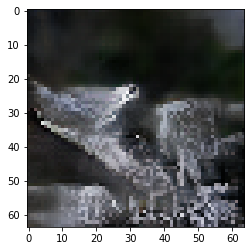

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 56

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.2373046875 sec
Gen loss: 1.3263175308219786, Disc loss: 3.7157503427851815, Disc valid real loss: 0.5595181916302782, Disc valid fake loss: 0.5090298092139123, Disc class real loss: 1.4597578765900154, Disc class fake loss: 1.1874444715698884
Time for epoch 2 is 14.285904169082642 sec
Gen loss: 1.318166963937806, Disc loss: 3.7257255351317284, Disc valid real loss: 0.5582432124995926, Disc valid fake loss: 0.5162231727505764, Disc class real loss: 1.462776312337012, Disc class fake loss: 1.1884828419866278
Time for epoch 3 is 14.249252319335938 sec
Gen loss: 1.3018340337567214, Disc loss: 3.728682215620832, Disc valid real loss: 0.5663854760044635, Disc valid fake loss: 0.5192265483906598, Disc class real loss: 1.457814619470095, Disc class fake loss: 1.1852555715940831
Time for epoch 4 is 14.268643617630005 sec
Gen loss: 1.2998487842761404, Disc l

Time for epoch 31 is 14.235399961471558 sec
Gen loss: 1.318015283362329, Disc loss: 3.71620133381872, Disc valid real loss: 0.5558700960503038, Disc valid fake loss: 0.5153549798135835, Disc class real loss: 1.4611648237156027, Disc class fake loss: 1.1838114379544245
Time for epoch 32 is 14.320106744766235 sec
Gen loss: 1.2861884244412265, Disc loss: 3.7355618748238415, Disc valid real loss: 0.5638570966436288, Disc valid fake loss: 0.5196915511193314, Disc class real loss: 1.4584486759128932, Disc class fake loss: 1.1935645522786995
Time for epoch 33 is 14.223215341567993 sec
Gen loss: 1.3201311558565796, Disc loss: 3.7287499607416996, Disc valid real loss: 0.5634024876566114, Disc valid fake loss: 0.515036251002211, Disc class real loss: 1.4600462109092776, Disc class fake loss: 1.1902650207038816
Time for epoch 34 is 14.25509786605835 sec
Gen loss: 1.3193307759639048, Disc loss: 3.7215239665695647, Disc valid real loss: 0.5574772313519868, Disc valid fake loss: 0.5139756208351312, 

Time for epoch 62 is 14.195401668548584 sec
Gen loss: 1.2926806702523375, Disc loss: 3.735170934258438, Disc valid real loss: 0.5617564875420517, Disc valid fake loss: 0.519903487952421, Disc class real loss: 1.4594495060644175, Disc class fake loss: 1.1940614510034804
Time for epoch 63 is 14.30106806755066 sec
Gen loss: 1.3236899671515798, Disc loss: 3.720021913368204, Disc valid real loss: 0.559098685417718, Disc valid fake loss: 0.5167859982507339, Disc class real loss: 1.4595775924077847, Disc class fake loss: 1.1845596452069476
Time for epoch 64 is 14.258161783218384 sec
Gen loss: 1.3238411380992672, Disc loss: 3.7252603585157935, Disc valid real loss: 0.5575028429347971, Disc valid fake loss: 0.5113697493787057, Disc class real loss: 1.4597092614910467, Disc class fake loss: 1.1966785131108146
Time for epoch 65 is 14.216644287109375 sec
Gen loss: 1.3122654667068627, Disc loss: 3.722935698542815, Disc valid real loss: 0.5523959331234619, Disc valid fake loss: 0.5182068918940175, D

Time for epoch 93 is 14.23840045928955 sec
Gen loss: 1.3187668026301274, Disc loss: 3.733754865522307, Disc valid real loss: 0.5657127502003336, Disc valid fake loss: 0.5168067833918543, Disc class real loss: 1.4597424391485487, Disc class fake loss: 1.1914928952852886
Time for epoch 94 is 14.328421354293823 sec
Gen loss: 1.3177961757189536, Disc loss: 3.7048657386283566, Disc valid real loss: 0.5560508049762023, Disc valid fake loss: 0.5111739806689544, Disc class real loss: 1.461815819507692, Disc class fake loss: 1.175825138402179
Time for epoch 95 is 14.277457475662231 sec
Gen loss: 1.2952562294355252, Disc loss: 3.732581853220456, Disc valid real loss: 0.5639685644366876, Disc valid fake loss: 0.5150232917571133, Disc class real loss: 1.4634777918094541, Disc class fake loss: 1.1901122092554564
Time for epoch 96 is 14.249310731887817 sec
Gen loss: 1.3189911755119883, Disc loss: 3.7293302896546154, Disc valid real loss: 0.5619468720463233, Disc valid fake loss: 0.5160470834269433, 

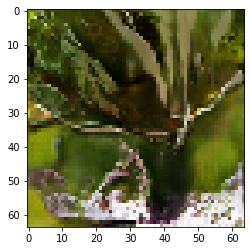

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 57

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.12583327293396 sec
Gen loss: 1.3233081116908934, Disc loss: 3.716169458740772, Disc valid real loss: 0.5556429403261117, Disc valid fake loss: 0.5134237316565785, Disc class real loss: 1.4569119318390926, Disc class fake loss: 1.1901908542728683
Time for epoch 2 is 14.271015405654907 sec
Gen loss: 1.3085010720462333, Disc loss: 3.7249124308588706, Disc valid real loss: 0.5524062560341223, Disc valid fake loss: 0.5221424088245485, Disc class real loss: 1.4586390179347217, Disc class fake loss: 1.1917247507307265
Time for epoch 3 is 14.309313297271729 sec
Gen loss: 1.313433267882846, Disc loss: 3.737606721841869, Disc valid real loss: 0.5617902936328071, Disc valid fake loss: 0.5198679398391951, Disc class real loss: 1.459820392332103, Disc class fake loss: 1.1961280981376565
Time for epoch 4 is 14.223581314086914 sec
Gen loss: 1.318453708799874, Dis

Time for epoch 31 is 14.220107316970825 sec
Gen loss: 1.2917876455195874, Disc loss: 3.734023779711426, Disc valid real loss: 0.5655456728890014, Disc valid fake loss: 0.5203963073126991, Disc class real loss: 1.4595160658766584, Disc class fake loss: 1.1885657362175506
Time for epoch 32 is 14.2410888671875 sec
Gen loss: 1.305743272711591, Disc loss: 3.7214708218406534, Disc valid real loss: 0.5595623313734525, Disc valid fake loss: 0.5167241093265978, Disc class real loss: 1.4614848605985564, Disc class fake loss: 1.1836995194921003
Time for epoch 33 is 14.218554496765137 sec
Gen loss: 1.312853487526498, Disc loss: 3.724258243876098, Disc valid real loss: 0.5574908352641232, Disc valid fake loss: 0.5180294912681993, Disc class real loss: 1.4589648511674669, Disc class fake loss: 1.1897730756258253
Time for epoch 34 is 14.276312112808228 sec
Gen loss: 1.2231287218044766, Disc loss: 3.8137323836970136, Disc valid real loss: 0.5734275732098556, Disc valid fake loss: 0.5453842959106776, D

Time for epoch 62 is 14.241138219833374 sec
Gen loss: 1.285627378842372, Disc loss: 3.725925520506655, Disc valid real loss: 0.5622797761021591, Disc valid fake loss: 0.519614587631329, Disc class real loss: 1.4612501963044247, Disc class fake loss: 1.1827809668491849
Time for epoch 63 is 14.241504669189453 sec
Gen loss: 1.3051387985870444, Disc loss: 3.724577164585351, Disc valid real loss: 0.5659895659623754, Disc valid fake loss: 0.5167845015118762, Disc class real loss: 1.459909553773358, Disc class fake loss: 1.181893548183648
Time for epoch 64 is 14.278166770935059 sec
Gen loss: 1.3123927646213107, Disc loss: 3.7267835902650828, Disc valid real loss: 0.5629323435831199, Disc valid fake loss: 0.5166970886350647, Disc class real loss: 1.4589791624203607, Disc class fake loss: 1.1881749935266448
Time for epoch 65 is 14.202163696289062 sec
Gen loss: 1.2854547578144848, Disc loss: 3.733265772744569, Disc valid real loss: 0.560134334858194, Disc valid fake loss: 0.5205177872323086, Dis

Time for epoch 93 is 14.196524858474731 sec
Gen loss: 1.30067164658854, Disc loss: 3.7328371504134923, Disc valid real loss: 0.5653785060091716, Disc valid fake loss: 0.5189411317914482, Disc class real loss: 1.4581960759511807, Disc class fake loss: 1.1903214365809267
Time for epoch 94 is 14.210472345352173 sec
Gen loss: 1.3080065113096055, Disc loss: 3.7224583703327956, Disc valid real loss: 0.5624228896002782, Disc valid fake loss: 0.5149889757962731, Disc class real loss: 1.4577516785805142, Disc class fake loss: 1.1872948265980252
Time for epoch 95 is 14.21802306175232 sec
Gen loss: 1.2711040196703056, Disc loss: 3.7407602488510006, Disc valid real loss: 0.5629252163052236, Disc valid fake loss: 0.5245643199136264, Disc class real loss: 1.4597081605011855, Disc class fake loss: 1.1935625505964285
Time for epoch 96 is 14.182775974273682 sec
Gen loss: 1.3140013624982136, Disc loss: 3.7196995016682117, Disc valid real loss: 0.5617199259883343, Disc valid fake loss: 0.5158414714704684

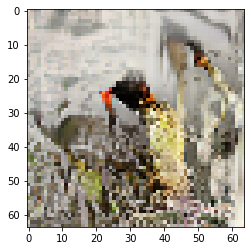

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 58

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.28658390045166 sec
Gen loss: 1.315610651078263, Disc loss: 3.7225542998895413, Disc valid real loss: 0.5622463831248968, Disc valid fake loss: 0.5159761177168952, Disc class real loss: 1.4607521576610039, Disc class fake loss: 1.183579645021175
Time for epoch 2 is 14.295286417007446 sec
Gen loss: 1.323278200497149, Disc loss: 3.7219610905582665, Disc valid real loss: 0.5561165518876983, Disc valid fake loss: 0.516496898762902, Disc class real loss: 1.4598522286428022, Disc class fake loss: 1.1894954068227834
Time for epoch 3 is 14.358534097671509 sec
Gen loss: 1.294544286036556, Disc loss: 3.737379513458831, Disc valid real loss: 0.5656735390667024, Disc valid fake loss: 0.5218346081775055, Disc class real loss: 1.4608779047239764, Disc class fake loss: 1.188993448972056
Time for epoch 4 is 14.338929414749146 sec
Gen loss: 1.296823668932204, Disc l

Time for epoch 31 is 14.279784202575684 sec
Gen loss: 1.2713143731843488, Disc loss: 3.7528503309420453, Disc valid real loss: 0.5676356335157947, Disc valid fake loss: 0.5295623053864735, Disc class real loss: 1.4583883873492398, Disc class fake loss: 1.1972640135746984
Time for epoch 32 is 14.209364891052246 sec
Gen loss: 1.3002498077183235, Disc loss: 3.7208065838025512, Disc valid real loss: 0.5551283831195779, Disc valid fake loss: 0.5226740099711793, Disc class real loss: 1.4592383434455893, Disc class fake loss: 1.183765849769923
Time for epoch 33 is 14.288845777511597 sec
Gen loss: 1.3204532687256976, Disc loss: 3.7238957636401584, Disc valid real loss: 0.5577904284808047, Disc valid fake loss: 0.5162767528033838, Disc class real loss: 1.4593357102980782, Disc class fake loss: 1.190492870038764
Time for epoch 34 is 14.204483032226562 sec
Gen loss: 1.3087866521140101, Disc loss: 3.719015596358757, Disc valid real loss: 0.5578588939456113, Disc valid fake loss: 0.5142898154129504

Time for epoch 62 is 14.321756362915039 sec
Gen loss: 1.2989298953273432, Disc loss: 3.726586574461402, Disc valid real loss: 0.5592783628925075, Disc valid fake loss: 0.5153246501758493, Disc class real loss: 1.4595550188850257, Disc class fake loss: 1.1924285366929321
Time for epoch 63 is 14.279953002929688 sec
Gen loss: 1.2999421698937248, Disc loss: 3.736866642143022, Disc valid real loss: 0.5637563789278511, Disc valid fake loss: 0.5212978627785112, Disc class real loss: 1.4592773966026824, Disc class fake loss: 1.192535006579991
Time for epoch 64 is 14.20493745803833 sec
Gen loss: 1.299860675322008, Disc loss: 3.71234547736522, Disc valid real loss: 0.5532086997981963, Disc valid fake loss: 0.5199316883797891, Disc class real loss: 1.4567949251753851, Disc class fake loss: 1.1824101652233259
Time for epoch 65 is 14.281806945800781 sec
Gen loss: 1.294421593994306, Disc loss: 3.740576924347296, Disc valid real loss: 0.5676778255277856, Disc valid fake loss: 0.515437971124158, Disc 

Time for epoch 93 is 14.231081485748291 sec
Gen loss: 1.2940621069130214, Disc loss: 3.740461962009833, Disc valid real loss: 0.5599654958984717, Disc valid fake loss: 0.5294060466412284, Disc class real loss: 1.4568886928118987, Disc class fake loss: 1.1942017170471875
Time for epoch 94 is 14.345774412155151 sec
Gen loss: 1.2991397959106983, Disc loss: 3.721797474031526, Disc valid real loss: 0.565706303368416, Disc valid fake loss: 0.5164996372651924, Disc class real loss: 1.4593655665715535, Disc class fake loss: 1.1802259706223237
Time for epoch 95 is 14.216455936431885 sec
Gen loss: 1.2985572047672944, Disc loss: 3.725086318768137, Disc valid real loss: 0.5581594816229853, Disc valid fake loss: 0.5173265338751681, Disc class real loss: 1.4590679526652102, Disc class fake loss: 1.1905323522200753
Time for epoch 96 is 14.284467935562134 sec
Gen loss: 1.2863140306498624, Disc loss: 3.7459172453014506, Disc valid real loss: 0.5669139219816461, Disc valid fake loss: 0.5237979471360442,

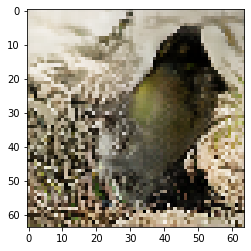

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 59

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 14.293071508407593 sec
Gen loss: 1.2955566974190194, Disc loss: 3.738080455681819, Disc valid real loss: 0.5669672393055789, Disc valid fake loss: 0.5233446077764196, Disc class real loss: 1.4607922061672056, Disc class fake loss: 1.1869763988789503
Time for epoch 2 is 14.205783128738403 sec
Gen loss: 1.304511323046232, Disc loss: 3.731739037082124, Disc valid real loss: 0.5597648621413119, Disc valid fake loss: 0.5179066468222031, Disc class real loss: 1.4580866650837223, Disc class fake loss: 1.1959808598042827
Time for epoch 3 is 14.253620147705078 sec
Gen loss: 1.2980459891360627, Disc loss: 3.7378469424519114, Disc valid real loss: 0.5658870361200193, Disc valid fake loss: 0.523586682672423, Disc class real loss: 1.4603033240248517, Disc class fake loss: 1.1880699001999728
Time for epoch 4 is 14.272391319274902 sec
Gen loss: 1.2876141817589117, D

Time for epoch 31 is 14.251632690429688 sec
Gen loss: 1.293920225567288, Disc loss: 3.7402309079157305, Disc valid real loss: 0.5652310015547889, Disc valid fake loss: 0.5208033193256151, Disc class real loss: 1.461981571786772, Disc class fake loss: 1.1922150167023264
Time for epoch 32 is 14.243908405303955 sec
Gen loss: 1.2787943568009994, Disc loss: 3.732612102012324, Disc valid real loss: 0.5650815477539207, Disc valid fake loss: 0.5245611910736011, Disc class real loss: 1.4615372332130991, Disc class fake loss: 1.1814321300524684
Time for epoch 33 is 14.237916469573975 sec
Gen loss: 1.2969602301191832, Disc loss: 3.738382050015416, Disc valid real loss: 0.5628406754354152, Disc valid fake loss: 0.5222711378965921, Disc class real loss: 1.4601490084071793, Disc class fake loss: 1.1931212203612496
Time for epoch 34 is 14.272345781326294 sec
Gen loss: 1.2886286563666531, Disc loss: 3.7386499846853862, Disc valid real loss: 0.561296725822335, Disc valid fake loss: 0.5223232575548373, 

Time for epoch 62 is 14.302245140075684 sec
Gen loss: 1.28885440500125, Disc loss: 3.733148481141584, Disc valid real loss: 0.5629641203699396, Disc valid fake loss: 0.5206497508658949, Disc class real loss: 1.4614725316443093, Disc class fake loss: 1.1880620732540037
Time for epoch 63 is 14.26603889465332 sec
Gen loss: 1.2914282881470553, Disc loss: 3.732462619378315, Disc valid real loss: 0.5664496236861882, Disc valid fake loss: 0.521961251086982, Disc class real loss: 1.4561916757728348, Disc class fake loss: 1.1878600719821486
Time for epoch 64 is 14.21993088722229 sec
Gen loss: 1.3011553198664492, Disc loss: 3.7279324182649938, Disc valid real loss: 0.56128583715214, Disc valid fake loss: 0.5178921621666368, Disc class real loss: 1.457105168159092, Disc class fake loss: 1.1916492463450445
Time for epoch 65 is 14.308560609817505 sec
Gen loss: 1.2835819789064609, Disc loss: 3.7372634953599637, Disc valid real loss: 0.5680104910842771, Disc valid fake loss: 0.5222844829565787, Disc 

Time for epoch 93 is 14.28873348236084 sec
Gen loss: 1.278543987248325, Disc loss: 3.7543981152821364, Disc valid real loss: 0.5702067482762221, Disc valid fake loss: 0.5265800050765195, Disc class real loss: 1.4607405168254202, Disc class fake loss: 1.196870844700149
Time for epoch 94 is 14.278739929199219 sec
Gen loss: 1.2847143571551254, Disc loss: 3.7251110083365506, Disc valid real loss: 0.5615405017121374, Disc valid fake loss: 0.5180019413229573, Disc class real loss: 1.4610951728614041, Disc class fake loss: 1.184473389532508
Time for epoch 95 is 14.296183347702026 sec
Gen loss: 1.2887002877426665, Disc loss: 3.737111563281961, Disc valid real loss: 0.5544557396958514, Disc valid fake loss: 0.5280912305281414, Disc class real loss: 1.4604636479199418, Disc class fake loss: 1.1941009346385636
Time for epoch 96 is 14.277837038040161 sec
Gen loss: 1.27848298795178, Disc loss: 3.7460739967945793, Disc valid real loss: 0.5645109094416869, Disc valid fake loss: 0.5246750162384375, Di

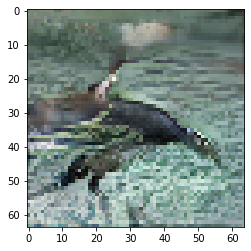

In [286]:
next_starting_checkpoint, totalepochs, warmup = long_train(starting_checkpoint=next_starting_checkpoint, 
                                      num_checkpoints=20, 
                                      checkpoint_interval=100, 
                                      g_hist=gen_loss_hist, 
                                      d_hist=disc_loss_hist,
                                      d_real_hist=disc_loss_real_hist,
                                      d_fake_hist=disc_loss_fake_hist,
                                      d_attr_real_hist=disc_attr_loss_real_hist,
                                      d_attr_fake_hist=disc_attr_loss_fake_hist,
                                      noise=noise100,
                                      attr=attr,
                                      save_files=True,
                                      warmup=warmup)

In [338]:
attr_df = pd.read_csv('CUB_200_2011/attributes.txt', sep=' ', header=None)
attr_df = attr_df.drop(0)
def description_from_vector(vec, df):
    indices = np.where(vec != 0)
#     s = ''
#     print(indices)
#     for idx in indices:
#         s += df[1][idx]
#     return s
    return df[1][indices[0]]
description_from_vector(attrs[0], attr_df)

6             has_bill_shape::all-purpose
10                  has_wing_color::brown
20                  has_wing_color::black
25            has_upperparts_color::brown
51            has_underparts_color::white
54              has_breast_pattern::solid
59                  has_back_color::brown
72                   has_back_color::buff
74           has_tail_shape::rounded_tail
80            has_upper_tail_color::brown
84             has_upper_tail_color::grey
99              has_head_pattern::eyebrow
117               has_breast_color::white
132               has_throat_color::white
145                  has_eye_color::black
151    has_bill_length::shorter_than_head
166              has_forehead_color::buff
168           has_under_tail_color::brown
178           has_under_tail_color::black
196                  has_nape_color::buff
209                has_belly_color::white
211                 has_belly_color::buff
213         has_wing_shape::pointed-wings
218            has_size::small_(5_

,0,1
1,2,has_bill_shape::dagger
2,3,has_bill_shape::hooked
3,4,has_bill_shape::needle
4,5,has_bill_shape::hooked_seabird
5,6,has_bill_shape::spatulate


7                    has_bill_shape::cone
20                  has_wing_color::black
21                  has_wing_color::white
35            has_upperparts_color::black
36            has_upperparts_color::white
50            has_underparts_color::black
51            has_underparts_color::white
56            has_breast_pattern::striped
69                  has_back_color::black
70                  has_back_color::white
75           has_tail_shape::notched_tail
99              has_head_pattern::eyebrow
116               has_breast_color::black
117               has_breast_color::white
132               has_throat_color::white
146                  has_eye_color::white
151    has_bill_length::shorter_than_head
157              has_forehead_color::grey
178           has_under_tail_color::black
179           has_under_tail_color::white
183                 has_nape_color::brown
187                  has_nape_color::grey
208                has_belly_color::black
209                has_belly_color

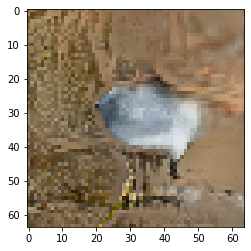

6             has_bill_shape::all-purpose
14                   has_wing_color::grey
15                 has_wing_color::yellow
20                  has_wing_color::black
29             has_upperparts_color::grey
30           has_upperparts_color::yellow
35            has_upperparts_color::black
44             has_underparts_color::grey
51            has_underparts_color::white
54              has_breast_pattern::solid
77           has_tail_shape::pointed_tail
95                has_head_pattern::malar
110                has_breast_color::grey
117               has_breast_color::white
132               has_throat_color::white
138                 has_eye_color::rufous
151    has_bill_length::shorter_than_head
163             has_forehead_color::black
173          has_under_tail_color::yellow
178           has_under_tail_color::black
179           has_under_tail_color::white
193                 has_nape_color::black
202                 has_belly_color::grey
209                has_belly_color

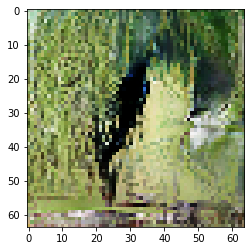

1                       has_bill_shape::dagger
14                        has_wing_color::grey
21                       has_wing_color::white
36                 has_upperparts_color::white
51                 has_underparts_color::white
54                   has_breast_pattern::solid
70                       has_back_color::white
76             has_tail_shape::fan-shaped_tail
91                 has_upper_tail_color::white
104                   has_head_pattern::capped
117                    has_breast_color::white
132                    has_throat_color::white
145                       has_eye_color::black
149    has_bill_length::about_the_same_as_head
163                  has_forehead_color::black
179                has_under_tail_color::white
193                      has_nape_color::black
209                     has_belly_color::white
215              has_wing_shape::tapered-wings
217               has_size::large_(16_-_32_in)
227                       has_shape::gull-like
236          

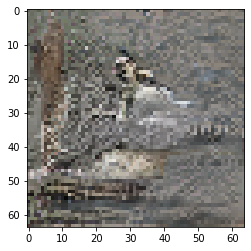

4          has_bill_shape::hooked_seabird
20                  has_wing_color::black
35            has_upperparts_color::black
44             has_underparts_color::grey
57      has_breast_pattern::multi-colored
69                  has_back_color::black
77           has_tail_shape::pointed_tail
90            has_upper_tail_color::black
96              has_head_pattern::crested
110                has_breast_color::grey
125                has_throat_color::grey
146                  has_eye_color::white
151    has_bill_length::shorter_than_head
157              has_forehead_color::grey
169      has_under_tail_color::iridescent
193                 has_nape_color::black
209                has_belly_color::white
213         has_wing_shape::pointed-wings
220          has_size::medium_(9_-_16_in)
225                  has_shape::duck-like
236               has_back_pattern::solid
240               has_tail_pattern::solid
247      has_belly_pattern::multi-colored
259              has_primary_color

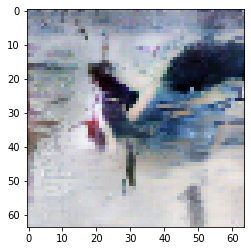

1                       has_bill_shape::dagger
14                        has_wing_color::grey
15                      has_wing_color::yellow
29                  has_upperparts_color::grey
30                has_upperparts_color::yellow
44                  has_underparts_color::grey
51                 has_underparts_color::white
54                   has_breast_pattern::solid
63                        has_back_color::grey
64                      has_back_color::yellow
75                has_tail_shape::notched_tail
84                  has_upper_tail_color::grey
100                  has_head_pattern::eyering
117                    has_breast_color::white
131                    has_throat_color::black
132                    has_throat_color::white
145                       has_eye_color::black
149    has_bill_length::about_the_same_as_head
158                 has_forehead_color::yellow
172                 has_under_tail_color::grey
178                has_under_tail_color::black
187          

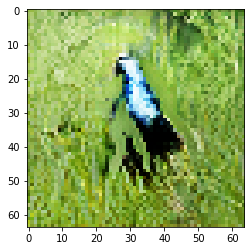

7                    has_bill_shape::cone
20                  has_wing_color::black
21                  has_wing_color::white
29             has_upperparts_color::grey
35            has_upperparts_color::black
36            has_upperparts_color::white
51            has_underparts_color::white
57      has_breast_pattern::multi-colored
77           has_tail_shape::pointed_tail
95                has_head_pattern::malar
98       has_head_pattern::unique_pattern
104              has_head_pattern::capped
116               has_breast_color::black
117               has_breast_color::white
125                has_throat_color::grey
145                  has_eye_color::black
151    has_bill_length::shorter_than_head
157              has_forehead_color::grey
163             has_forehead_color::black
172            has_under_tail_color::grey
187                  has_nape_color::grey
209                has_belly_color::white
218            has_size::small_(5_-_9_in)
235              has_shape::perchi

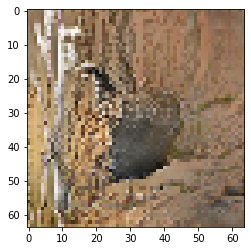

1                       has_bill_shape::dagger
14                        has_wing_color::grey
23                        has_wing_color::buff
29                  has_upperparts_color::grey
38                  has_upperparts_color::buff
63                        has_back_color::grey
72                        has_back_color::buff
93                  has_upper_tail_color::buff
99                   has_head_pattern::eyebrow
125                     has_throat_color::grey
145                       has_eye_color::black
149    has_bill_length::about_the_same_as_head
157                   has_forehead_color::grey
172                 has_under_tail_color::grey
181                 has_under_tail_color::buff
187                       has_nape_color::grey
193                      has_nape_color::black
218                 has_size::small_(5_-_9_in)
235                   has_shape::perching-like
239            has_back_pattern::multi-colored
242                  has_tail_pattern::striped
253          

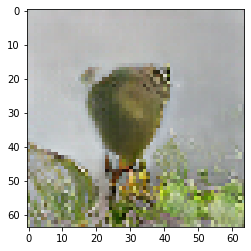

7                    has_bill_shape::cone
14                   has_wing_color::grey
15                 has_wing_color::yellow
29             has_upperparts_color::grey
30           has_upperparts_color::yellow
45           has_underparts_color::yellow
54              has_breast_pattern::solid
63                   has_back_color::grey
64                 has_back_color::yellow
75           has_tail_shape::notched_tail
101               has_head_pattern::plain
111              has_breast_color::yellow
126              has_throat_color::yellow
145                  has_eye_color::black
151    has_bill_length::shorter_than_head
158            has_forehead_color::yellow
188                has_nape_color::yellow
203               has_belly_color::yellow
212         has_wing_shape::rounded-wings
218            has_size::small_(5_-_9_in)
235              has_shape::perching-like
238             has_back_pattern::striped
244              has_belly_pattern::solid
254             has_primary_color:

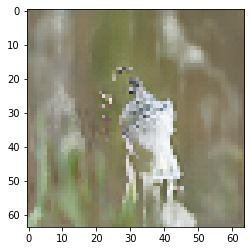

7                    has_bill_shape::cone
10                  has_wing_color::brown
51            has_underparts_color::white
57      has_breast_pattern::multi-colored
95                has_head_pattern::malar
117               has_breast_color::white
121               has_throat_color::brown
145                  has_eye_color::black
151    has_bill_length::shorter_than_head
153             has_forehead_color::brown
194                 has_nape_color::white
209                has_belly_color::white
216            has_wing_shape::long-wings
221       has_size::very_small_(3_-_5_in)
231                  has_shape::hawk-like
245            has_belly_pattern::spotted
249              has_primary_color::brown
260              has_primary_color::white
264                  has_leg_color::brown
279                 has_bill_color::brown
290                 has_bill_color::white
294                has_crown_color::brown
Name: 1, dtype: object


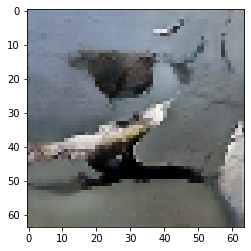

6             has_bill_shape::all-purpose
45           has_underparts_color::yellow
56            has_breast_pattern::striped
75           has_tail_shape::notched_tail
101               has_head_pattern::plain
106               has_breast_color::brown
111              has_breast_color::yellow
126              has_throat_color::yellow
145                  has_eye_color::black
151    has_bill_length::shorter_than_head
158            has_forehead_color::yellow
183                 has_nape_color::brown
188                has_nape_color::yellow
203               has_belly_color::yellow
218            has_size::small_(5_-_9_in)
235              has_shape::perching-like
244              has_belly_pattern::solid
254             has_primary_color::yellow
277                   has_leg_color::buff
289                 has_bill_color::black
299               has_crown_color::yellow
Name: 1, dtype: object


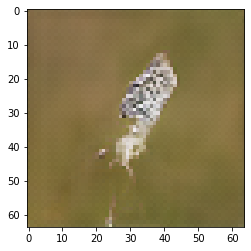

In [357]:
attrs = train_attrs[np.random.choice(range(len(train_attrs)), 10, replace=False)]
noise = np.random.normal(0, 1, 100)
for i in range(10):
#     print(attrs[i])
    print(description_from_vector(attrs[i], attr_df))
    generated_image = generator.predict([np.array([noise]), np.array([attrs[i]])] )[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()
#     break

In [ ]:
print(img_classes)
noise = np.random.normal(0, 1, 100)
for label in range(10):
    generated_image = generator.predict([np.array([noise]), np.array([label])] )[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.title(img_classes[label])
    plt.show()

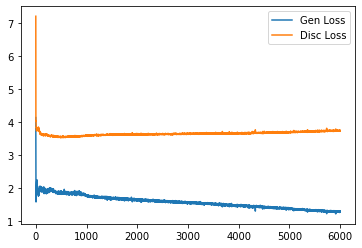

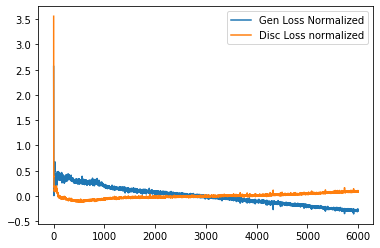

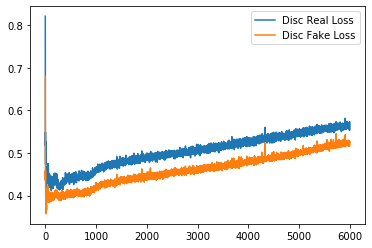

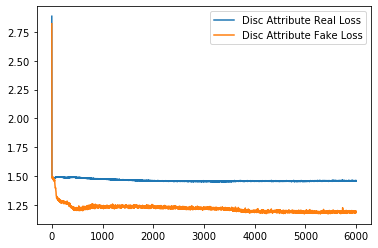

In [358]:
plt.plot(gen_loss_hist)
plt.plot(disc_loss_hist)

plt.legend(['Gen Loss','Disc Loss'])
plt.show()

plt.plot(gen_loss_hist - np.mean(gen_loss_hist))
plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
plt.legend(['Gen Loss Normalized','Disc Loss normalized'])
plt.show()

plt.plot(disc_loss_real_hist)
plt.plot(disc_loss_fake_hist)
plt.legend(['Disc Real Loss','Disc Fake Loss'])
plt.show()

plt.plot(disc_attr_loss_real_hist)
plt.plot(disc_attr_loss_fake_hist)
plt.legend(['Disc Attribute Real Loss', 'Disc Attribute Fake Loss'])
plt.show()


In [ ]:
noise = tf.random.truncated_normal([32, 100])
tf.dtypes.cast(noise, tf.int32)


In [ ]:
for i in range(20,30):
    plt.imshow(unnormalize_img(train_imgs[i]))
    plt.title(img_classes[int(train_classes[i])])
    plt.show()

In [ ]:
intermediate_layer_model = Model(inputs=generator.input[1],
                                 outputs=generator.layers[2].output)


In [ ]:
total = None
for label in range(10):
    if total is None:
        total = np.abs(intermediate_layer_model.predict(np.array([label]))[0][0])
    total += np.abs(intermediate_layer_model.predict(np.array([label]))[0][0])
print(total)

In [ ]:
intermediate_layer_model.predict(np.array([0]))[0][0]

In [ ]:
test_gen = make_generator_model((100,))

In [ ]:
test_gen_embedding = Model(inputs=test_gen.input[1],
                                 outputs=test_gen.layers[2].output)

In [ ]:
test_gen_embedding.predict(np.array([7]))[0][0]

In [ ]:
for i in range(10):
    plt.imshow(unnormalize_img(train_imgs[i]))
    plt.title(img_classes[int(train_classes[i])])
    plt.show()